In [1]:
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

%matplotlib inline

#1 figure for ov bi model, sensitivity to sine amplitude in initial conditions
# the rest of the notebook is exploration

$$\dot \theta_j = \omega_0 - \frac{K}{2} \left[ {\rm tanh} \left( \frac{ \cos\theta_{j-1} - \cos\theta_{j} - \beta}{h_{ol}} \right) + 1\right]  $$ 
$$ - \nu_p  \sin( \theta_j- \theta_{j+1}) -\nu_m \sin(\theta_j - \theta_{j-1})$$
$$ + \nu_{cp}  \cos( \theta_j- \theta_{j+1}) + \nu_{cm} \cos(\theta_j- \theta_{j-1})$$
$$ + A_c \cos(\theta_j + \theta_{j+1}) + A_s \sin(\theta_j + \theta_{j+1}) 
+ A_c \cos(\theta_j + \theta_{j-1}) + A_s \sin(\theta_j + \theta_{j-1})$$

The local Kuramoto model is $K_s = A_c = A_s = 0$ and $\nu >0$. 
The simple Niedermayer model has $\nu_p=\nu_p>0$ an $\nu_{cp} = \nu_{cm}>0$.

Sign or order of inside of $\nu_c$ cosine terms is irrelevant! 


This model encompases a vanilla phase oscillator model along with one sided overlap term and some terms
that involve sums of angles


$$ \cos(\theta_j + \theta_{j+1}  ) + \cos (\theta_j + \theta_{j-1})  = 2 \cos (( 2\theta_j + \theta_{j+1} + \theta_{j-1})/2) \cos((\theta_{j+1} - \theta_{j+1})/2) $$ 
$$ \sin(\theta_j + \theta_{j+1}  ) + \sin (\theta_j + \theta_{j-1})  = 
2 \sin (( 2\theta_j + \theta_{j+1} + \theta_{j-1})/2) \cos((\theta_{j+1} - \theta_{j+1})/2) $$

In [66]:
# functions for phase oscillator models 
# up is theta_j+1
# um is theta_j-1
# uj is theta_j

# function used to find dudt
def du_fun_overlap(up,uj,um,parms):
    omega0=parms[0]
    K    = parms[1]
    nu_p = parms[2]
    nu_m = parms[3]
    nu_cp = parms[4]
    nu_cm = parms[5]
    beta = parms[6]
    hor = parms[7]
    hol = hor
    A_c = parms[8]
    A_s = parms[9]
    #overlap_right = np.cos(uj) - np.cos(up) - beta
    #tor = K*0.5*(np.tanh(overlap_right/hor) + 1.)
    #du_j = omega0 - tor;
    overlap_left  = np.cos(um) - np.cos(uj) - beta
    tol = K*0.5*(np.tanh(overlap_left/hol) + 1.)
    du_j = omega0 - tol;
    du_j += nu_p*np.sin(up -uj)+ nu_m*np.sin(um-uj)  # some diffusion if you want it
    du_j += nu_cp*np.cos(up -uj)+ nu_cm*np.cos(um-uj)
    du_j += A_c*np.cos(uj + up) + A_s*np.sin(uj + up)  # neidermayer like sum terms
    du_j += A_c*np.cos(uj + um) + A_s*np.sin(uj + um)
    return du_j

# compute dudt
def du(func,u_arr,parms):
    up = np.copy(np.roll(u_arr,-1))  #periodic bc
    um = np.copy(np.roll(u_arr,1))
    uj = np.copy(u_arr)
    du_arr = func(up,uj,um,parms)
    return du_arr


isang = 1 # if u is an angle or not
twopi = 2*np.pi
#np.random.seed(2)


# take one step using 4th order Runge-kutta
# https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods
# do a time step on the theta array
def update_onestep_rk4(func,u_arr,parms,dt):
    k1 = du(func,u_arr          ,parms)
    k2 = du(func,u_arr + dt*k1/2,parms)
    k3 = du(func,u_arr + dt*k2/2,parms)
    k4 = du(func,u_arr + dt*k3  ,parms)
    yn1 = u_arr + dt*(k1 + 2*k2 + 2*k3 + k4)/6.0
    #u_arr = u_arr + dudt*dt
    u_arr = yn1
    # add Gaussian white noise. Its integral is a Wiener process (like random walk)
    eta = parms[12]
    #
    u_arr += np.sqrt(eta*dt)*np.random.normal(size=len(u_arr))
    if (isang==1):
        u_arr = np.mod(u_arr,twopi)
        
    return u_arr


# do nsteps time steps on the theta array
def update_nsteps(func,u_arr,parms,dt,nsteps):
    for i in range(nsteps):
        u_arr = update_onestep_rk4(func,u_arr,parms,dt)
    return u_arr

In [3]:
# different types of initial conditions
# iparms determine parmeters for initial conditions 
def give_init(N,iparms):
    eta_rand   =iparms[0]  # random uniform 
    slope_ramp =iparms[1]  # slope of a ramp
    mag_sin    =iparms[2]  # mag of a sine perturbation, 
    index_sin  =iparms[3]  # sets wavelength of sine
    phase_sin = iparms[4]  # set phase 
    peak       =iparms[5]  # make one point this value, choose point randomly
    iroll_ramp  =int(iparms[6])  # shift of the ramp, allows you to set step discontinuity location
    #npeaks     =iparms[5]  # if >1 then randomly choose npeaks positions to give a peak value
    u_arr = np.zeros(N)  #allocate, zero initial conditions 
    u_arr += eta_rand*np.random.random(size=N)  # random everywhere, uniform distn
    irr = int(np.random.random()*N)  # one randomly chosen location has value peak
    u_arr[irr] = peak 
    phi = np.random.random()*2*np.pi # randomly chosen phase
    for i in range(N): # sinusoidal
        #u_arr[i] += mag_sin*np.sin(2*np.pi*i*index_sin/N + phi)  # index_sin sets wavelength
        u_arr[i] += mag_sin*np.sin(2*np.pi*i*index_sin/N + phase_sin)  # index_sin sets wavelength
    ii = np.arange(N)
    ramp = (2*np.pi*slope_ramp*ii/N)
    ramp = np.roll(ramp,iroll_ramp)
    u_arr += ramp # ramp

    return u_arr%(2*np.pi)  # keep within [0,2pi]


In [4]:
# compute phase difference
# as defined in Denes+21
# phi_i = theta_i - theta_i-1 - 2 pi floor( (theta_i - theta_i-1 + pi) /2pi) 
# should return numbers between [-pi,pi]
# also returns the cummulative sum of the phase shifts
def phase_shift(u_arr):
    uj = np.copy(u_arr)
    um = np.roll(uj,1)
    fac = (uj - um + np.pi)/(2*np.pi)
    phi_j = uj - um - 2*np.pi*np.floor(fac)
    csum = np.cumsum(phi_j) # cummulative sum of the phase differences 
    return phi_j,csum
    

In [5]:

colorlist = ['red','orange','gold','green','dodgerblue','blue','magenta','violet','brown']
ncolorlist = len(colorlist)


# do integration
# fill an image with array outputs of uarr at different times
# start with nsteps, separation between outs is dn (in steps)
# and have ndn rows
# returns 2d arrays
# first one is nsteps*dt
# remaining separations are dn*dt
# number of outputs is ndn
# returns:
#  uarr arrays
#  dudt arrays
#  phase differences (as in Denes) arrays
#  winding number array for the output timestep
def mkphaseprofile(func,N,parms,dt,nsteps,dn,ndn,iparms):
    u_arr0 = give_init(N,iparms)  # get initial conditions
    ndt=0;
    nsteps_pass=nsteps  # number of steps to first one
    uout_arr = np.zeros((ndn,N))
    dudt_arr = np.zeros((ndn,N))
    dudj_arr = np.zeros((ndn,N))
    csum_arr = np.zeros((ndn,N))
    u_arr = update_nsteps(func,u_arr0,parms,dt,nsteps_pass) # integrate
    du_arr = du(func,u_arr,parms)
    phi_j,csum = phase_shift(u_arr) 
    du_dj = phi_j
    #du_dj = (np.roll(u_arr,-1) - u_arr)%twopi # u_j+1-u_j
    #kk = (du_dj > np.pi)
    #du_dj[kk] -= twopi
    uout_arr[0,:] = u_arr
    dudt_arr[0,:] = du_arr
    dudj_arr[0,:] = du_dj
    csum_arr[0,:] = csum
    nsteps_pass = dn #steps per row  # steps per row on subsequent ones
    winding_number = np.zeros(ndn)
    winding_number[0] = np.sum(phi_j)/(2*np.pi)
    for k in range(1,ndn):  #ndn is number of rows
        u_arr = update_nsteps(func,u_arr,parms,dt,nsteps_pass) # integrate
        du_arr = du(func,u_arr,parms)
        phi_j,csum = phase_shift(u_arr)  # compute phase shift as via Denes+11
        #du_dj = (np.roll(u_arr,-1) - u_arr)%twopi
        du_dj = phi_j
        #kk = (du_dj > np.pi)
        #du_dj[kk] -= twopi
        uout_arr[k,:] = u_arr
        dudt_arr[k,:] = du_arr
        dudj_arr[k,:] = du_dj  # is now phase shift
        winding_number[k] = np.sum(phi_j)/(2*np.pi)
        winding_number[k] = csum[-1]/(2*np.pi)
        csum_arr[k,:] = csum
          
    return uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number


# plot theta for a list of outputs
def pltlist(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ilist,ofile):
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 3), \
                       sharex=True, sharey=False,dpi=300)
    plt.subplots_adjust(left=0.15, right=0.8,\
                        bottom=0.17,top=0.98,hspace=0)
    for i in range(len(ilist)):
        k = int(ilist[i])
        uarr = np.squeeze(uout_arr[k,:])
        ax.plot(uarr,'o-',color=colorlist[i%ncolorlist],ms=2)
        print('t={:.2f}'.format(tarr[k]))
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=300)
        
        
# plot theta for a list of outputs
def pltlist_mean(uout_arr,dudt_arr,dudj_arr,winding_number,dt,nsteps,dn,ndn,ilist,offsets,ofile):
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 2.2), \
                       sharex=True, sharey=False,dpi=300,facecolor='white')
    plt.subplots_adjust(left=0.15, right=0.98,\
                        bottom=0.22,top=0.98,hspace=0)
    for i in range(len(ilist)):
        k = int(ilist[i])
        uarr = np.squeeze(uout_arr[k,:])
        csum = np.sum(np.cos(uarr))
        ssum = np.sum(np.sin(uarr))
        umean = np.arctan2(ssum,csum)
        ushift = (uarr - umean + offsets[i] + np.pi)%(2*np.pi) -np.pi
        ax.plot(ushift,'o',color=colorlist[i%ncolorlist],ms=1,alpha=0.7)
        print('time t={:.2f}'.format(tarr[k]))
        
    ax.set_xlabel('index j',fontsize=14)
    ax.set_ylabel(r'$\theta$ + offset',fontsize=14)
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=300)   
        


In [6]:

# plots angle as an image along with winding number along with cummulative sum of phase diff
def newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,\
                dt,nsteps,dn,ndn,ofile,pos,alabel):
    nw=4
    fig, axarr = plt.subplots(nw, 1, figsize=(6, 4), \
                       sharex=True, sharey=False,dpi=300,facecolor='white')
    plt.subplots_adjust(left=0.15, right=0.8,\
                        bottom=0.17,top=0.98,hspace=0)
    for k in range(nw):
        axarr[k].tick_params(axis='both', which='minor', labelsize=14)
        axarr[k].tick_params(axis='both', which='major', labelsize=14)
        
    ytx = axarr[0].yaxis.get_major_ticks()
    ytx = axarr[1].yaxis.get_major_ticks()
    ytx[-1].set_visible(False)
    ytx[0].set_visible(False)
    
    tmin = nsteps*dt
    tmax = tmin + ndn*dn*dt
    tarr = np.linspace(tmin,tmax,ndn+1)
    jarr = np.arange(N+1)
    
    im0=axarr[0].pcolormesh(tarr,jarr,\
                np.transpose(uout_arr),vmin=0,vmax=twopi,cmap='hsv')
    l, b, w, h = axarr[0].get_position().bounds
    rect0 = (l+w+0.01),b,0.02,h #l, b, w, h
    ax_cb0 = fig.add_axes(rect0)
    fig.add_axes(ax_cb0)
    cbar0=plt.colorbar(im0,cax=ax_cb0,\
                    ticks=[0, np.pi, 2*np.pi],aspect=5,pad=0.02) 
    cbar0.ax.set_yticklabels(['0', r'$\pi$',r'$2\pi$'])
    cbar0.set_label(r'$\theta_j$',fontsize=14)
    
    im1=axarr[1].pcolormesh(tarr,jarr,\
                np.transpose(csum_arr)/(2*np.pi),cmap='rainbow')
    l, b, w, h = axarr[1].get_position().bounds
    rect1 = (l+w+0.01),b,0.02,h #l, b, w, h
    ax_cb1 = fig.add_axes(rect1)
    fig.add_axes(ax_cb1)
    cbar1=plt.colorbar(im1,cax=ax_cb1,\
                    aspect=5,pad=0.02) 
    cbar1.set_label(r'$w_j$',fontsize=14)
    
    im2=axarr[2].pcolormesh(tarr,jarr,np.transpose(dudj_arr),\
                vmin=-np.pi,vmax=np.pi,cmap='coolwarm')
    l, b, w, h = axarr[2].get_position().bounds
    rect2 = (l+w+0.01),b,0.02,h #l, b, w, h
    ax_cb2 = fig.add_axes(rect2)
    fig.add_axes(ax_cb2)
    cbar2=plt.colorbar(im2,cax=ax_cb2,\
                    ticks=[-np.pi,-np.pi/2,0,np.pi/2],aspect=5,pad=0.02) 
    cbar2.ax.set_yticklabels([r'-$\pi$',r'-$\pi$/2','0', r'$\pi$/2'])
    cbar2.set_label(r'$\phi_j$',fontsize=14)
    

    axarr[nw-1].plot(tarr[0:ndn],winding_number,'.',ms=3)
    axarr[nw-1].set_xlabel('time t',fontsize=14)
    axarr[nw-1].set_ylabel('winding w',fontsize=12)
    bottom, top = axarr[nw-1].get_ylim()
    if (np.abs(bottom) + np.abs(top) < 1.5):
        axarr[nw-1].set_ylim([-1.5,1.5])
    axarr[0].text(pos[0],pos[1],alabel,fontsize=16)
    for k in range(nw-1):
        axarr[k].set_ylabel('j',fontsize=14)
    
    
    if (len(ofile)>3):
        plt.savefig(ofile)
        


In [7]:
# compute standard deviation of phase diff array
def phivar(phi_arr):
    ss = np.shape(phi_arr)
    ndn = ss[0]
    phisig_arr = np.zeros(ndn)
    for k in range(ndn):
        #phimean = np.mean(phi_arr[k,:])
        phisig_arr[k] = np.std(phi_arr[k,:])
    return phisig_arr    
        

In [67]:
# loop over sine amplitude and Ku with fixed nu for overlap+bimod model
def doloop_2d_ov(index_sin,nu,Kustart,Ku_fac,Astart,A_fac,N,ni,nj,doit):
    
    dt=0.05
    func = du_fun_overlap
    ndn=600; dn=15; nsteps=dn
    print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
    parms = np.zeros(20)
    hol=0.05; beta=0.1;  A_c = 0.; A_s = 0.; 
    omega0=1.0
    # initial conditions 
    eta_rand=0*np.pi; slope_ramp = 0.0; 
    peak = 0; iroll_ramp = 10
    phase_sin = 0.0;
    nu_cp = 0.0; nu_cm = nu_cp;
    
    #ni = 5; nj = 5
    Ku_arr = np.zeros((ni,nj))
    w_arr = np.zeros((ni,nj))
    A_arr = np.zeros((ni,nj))

    print('Ku range {:.4f} {:.4f}'.format(Kustart,Kustart*np.power(Ku_fac,ni-1)))
    print('A range {:.4f} {:.4f}'.format(Astart,Astart*np.power(A_fac,nj-1)))
        
    for i in range(ni):
        Ku = Kustart*np.power(Ku_fac,i);
        for j in range(nj):
            Ku_arr[i,j] = Ku
            A = Astart*np.power(A_fac,j);
            A_arr[i,j] = A
            mag_sin = A
            # lopsided niedermayer model 
            
            parms[0] = omega0
            parms[1] = Ku
            parms[2] = nu_p
            parms[3] = nu_m
            parms[4] = nu_cp
            parms[5] = nu_cm
            parms[6] = beta
            parms[7] = hol
            parms[8] = A_c
            parms[9] = A_s

            # initial conditions 
            iparms = np.array([eta_rand,slope_ramp, mag_sin, \
                               index_sin,phase_sin,peak,iroll_ramp])
            u_arr0 = give_init(N,iparms)
            
            if (doit==1):
                uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)

                print('winding from', np.rint(winding_number[0]),' to ',np.rint(winding_number[-1]))
                w_arr[i,j] = np.rint(winding_number[-1])
        
    return Ku_arr,A_arr,w_arr

N_ov=64
index_sin=4; nu_ov=0.01; #nu_cp=0.0
Kustart=0.01; Ku_fac = 1.5
Astart=0.01; A_fac=1.5
ni=10;nj=10

Ku_arr_2d_ov,mag_sin_arr_2d_ov,w_arr_2d_ov = doloop_2d_ov(index_sin,nu_ov,\
                                Kustart,Ku_fac,Astart,A_fac,N_ov,ni,nj,1)

tmax = 451
Ku range 0.0100 0.3844
A range 0.0100 0.3844
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  -0.0
winding from 0.0  to  -0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
winding from 0.0  to  0.0
windin

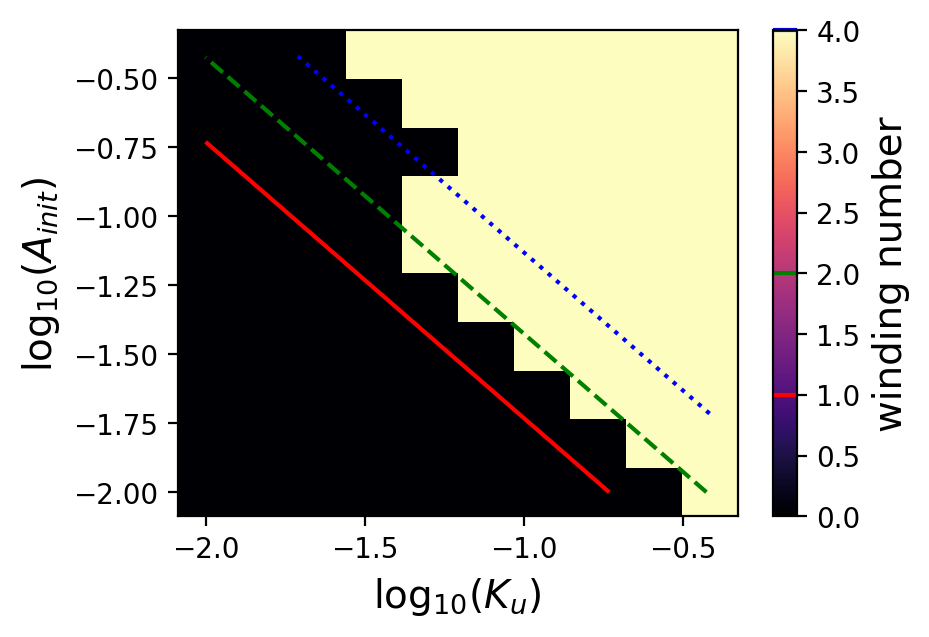

In [68]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.18,right=0.88,bottom=0.17,top=0.98)
im=ax.pcolormesh(np.log10(Ku_arr_2d_ov),np.log10(mag_sin_arr_2d_ov),\
                 w_arr_2d_ov,cmap='magma')  
ax.set_xlabel(r'$\log_{10}(K_u)$',fontsize=14)
ax.set_ylabel(r'$\log_{10}(A_{init})$',fontsize=14)
cbar = plt.colorbar(im)
cbar.set_label('winding number',fontsize=14)


dx = 2*np.pi/N_ov
max_slope_arr = mag_sin_arr_2d_ov*index_sin 
dx_maxs = max_slope_arr*dx
crit_arr = 27*Ku_arr_2d_ov *dx_maxs/(2*nu_ov)
CC = ax.contour(np.log10(Ku_arr_2d_ov),np.log10(mag_sin_arr_2d_ov),crit_arr,
                levels=[1,2,4],\
                colors=['red','green','blue'],\
                linestyles=['solid', 'dashed',  'dotted']) #'dashdot',
cbar.add_lines(CC)
plt.savefig('crit_contour_ov.png',dpi=300)
#xlin = np.linspace(np.log10(np.min(Ku_arr)),np.log10(np.min(Ku_arr)),10)
#ylin = xlin*0 + np.log10()
# ycrit = A *2pi *nlambda/N *c2a/c1s

In [ ]:
########################################

tmax = 601
winding from 0.0  to  3.0
phisig at end 0.1110 rad, 6.3585 deg


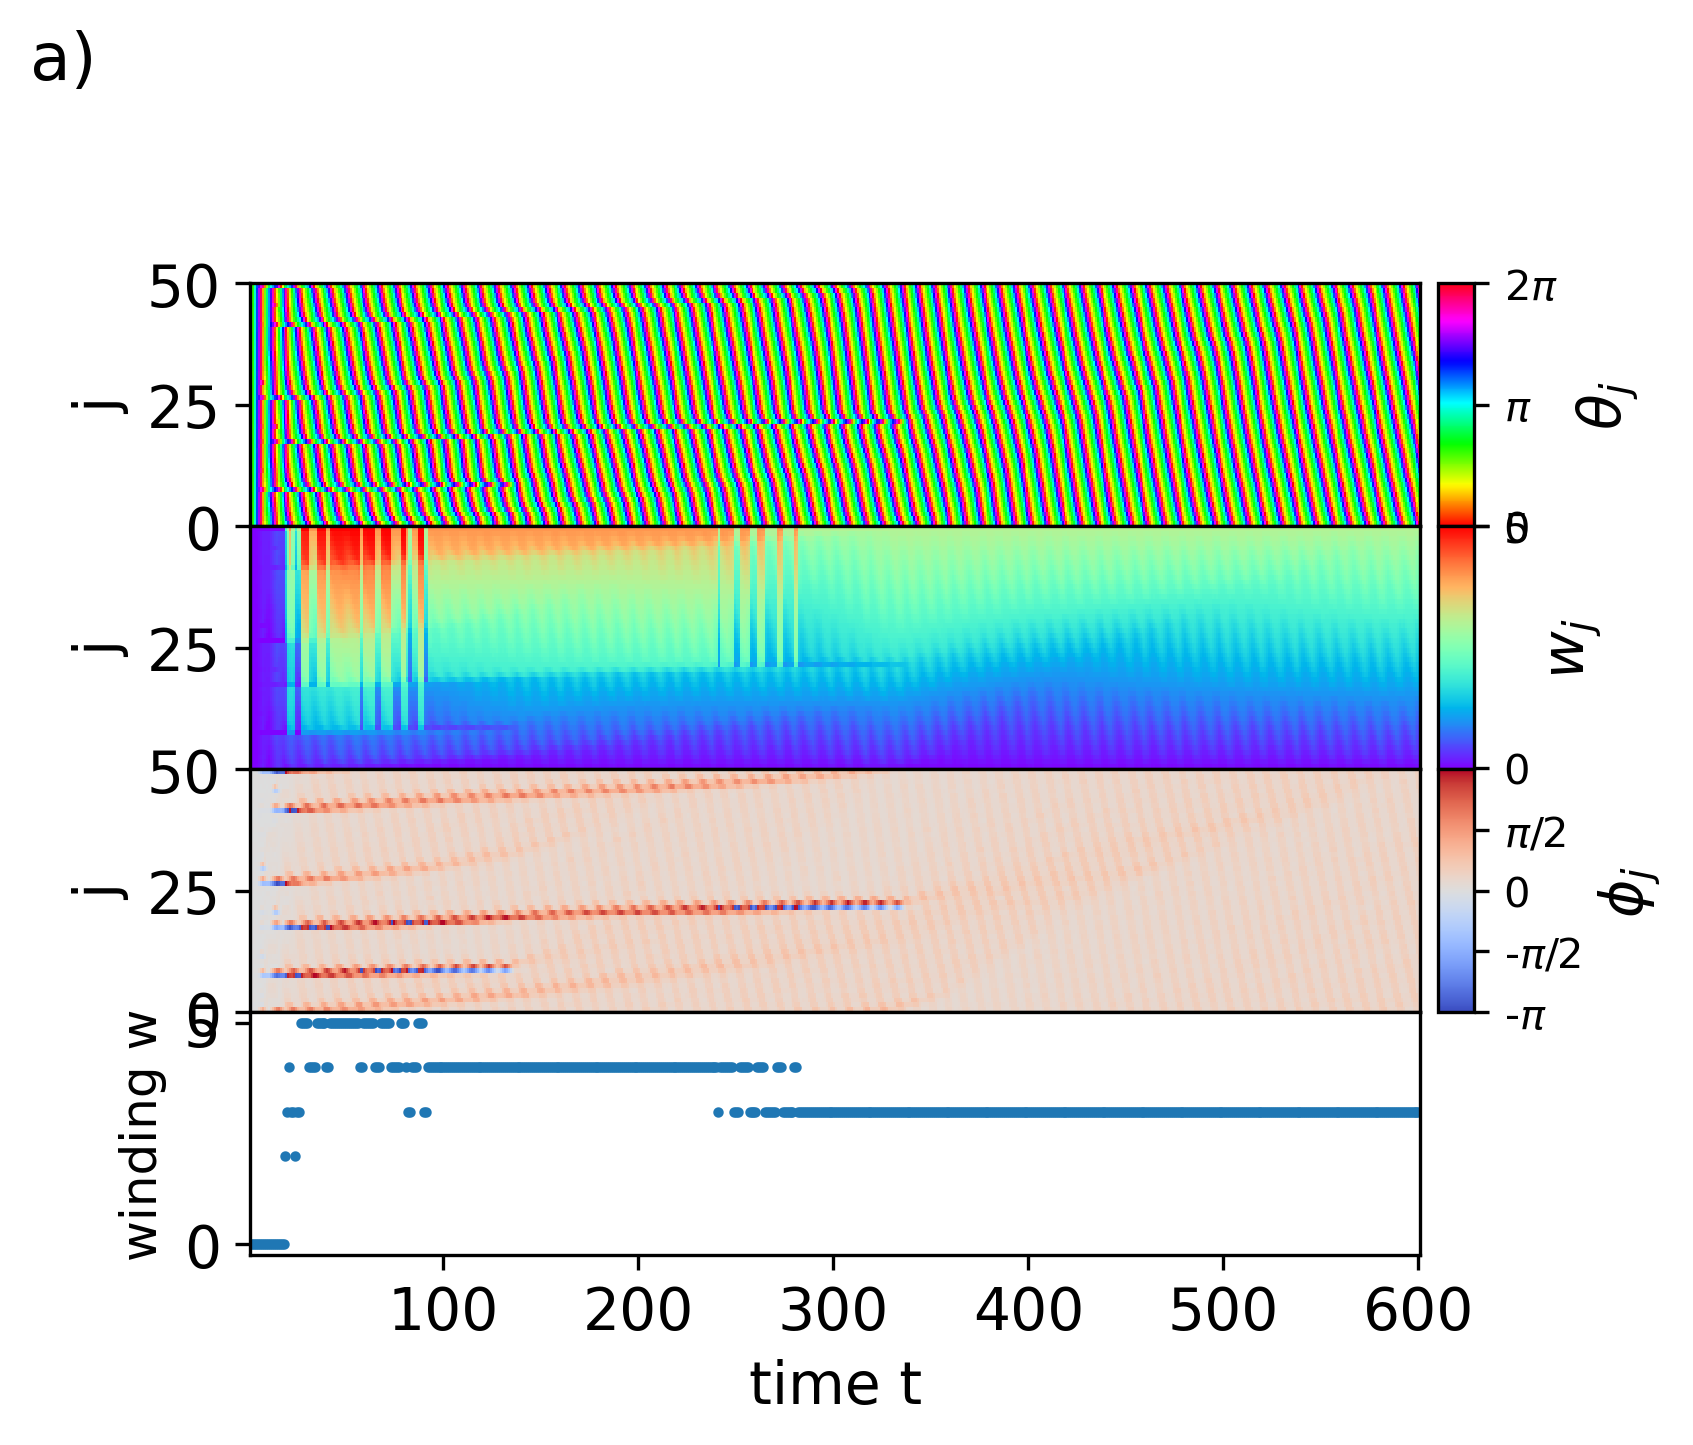

In [9]:
# overlap model + some diffusion , stochastic exploration!
hol=0.05; beta=0.1;  A_c = 0.; A_s = 0.; 
omega0=1.;  nu_cp = 0.0; nu_cm = 0.00;

K_u=0.5;      
nu_p=0.002; nu_m=nu_p;
eta = 1e-4  # noise

parms = np.zeros(20)
parms[0] = omega0; parms[1] = K_u;parms[2] = nu_p; parms[3] = nu_m; parms[4] = nu_cp;
parms[5] = nu_cm; parms[6] = beta;  parms[7] = hol; parms[8] = A_c; parms[9] = A_s;

parms[12] = eta # Gaussian white noise! sqrt(dt*eta)*normal distn
dt=0.05
func = du_fun_overlap

# initial conditions, flat
N=50; eta_rand=0*np.pi; slope_ramp = 0.0;  mag_sin = 0.0; index_sin = 4;  phase_sin = 0.0;  
peak = 0; iroll_ramp = 10
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])
u_arr0 = give_init(N,iparms)

ndn=600; dn=20; nsteps=dn
print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)

ofile="OVN1.png"; 
pos=[-112,92]; alabel="a)"
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)
print('winding from', np.rint(winding_number[0]),' to ', np.rint(winding_number[-1]))
phisig_arr = phivar(dudj_arr)
print('phisig at end {:.4f} rad, {:.4f} deg'.format(\
                        phisig_arr[-1],phisig_arr[-1]*180/np.pi))

tmax = 601
winding from 0.0  to  5.0
phisig at end 0.1198 rad, 6.8625 deg


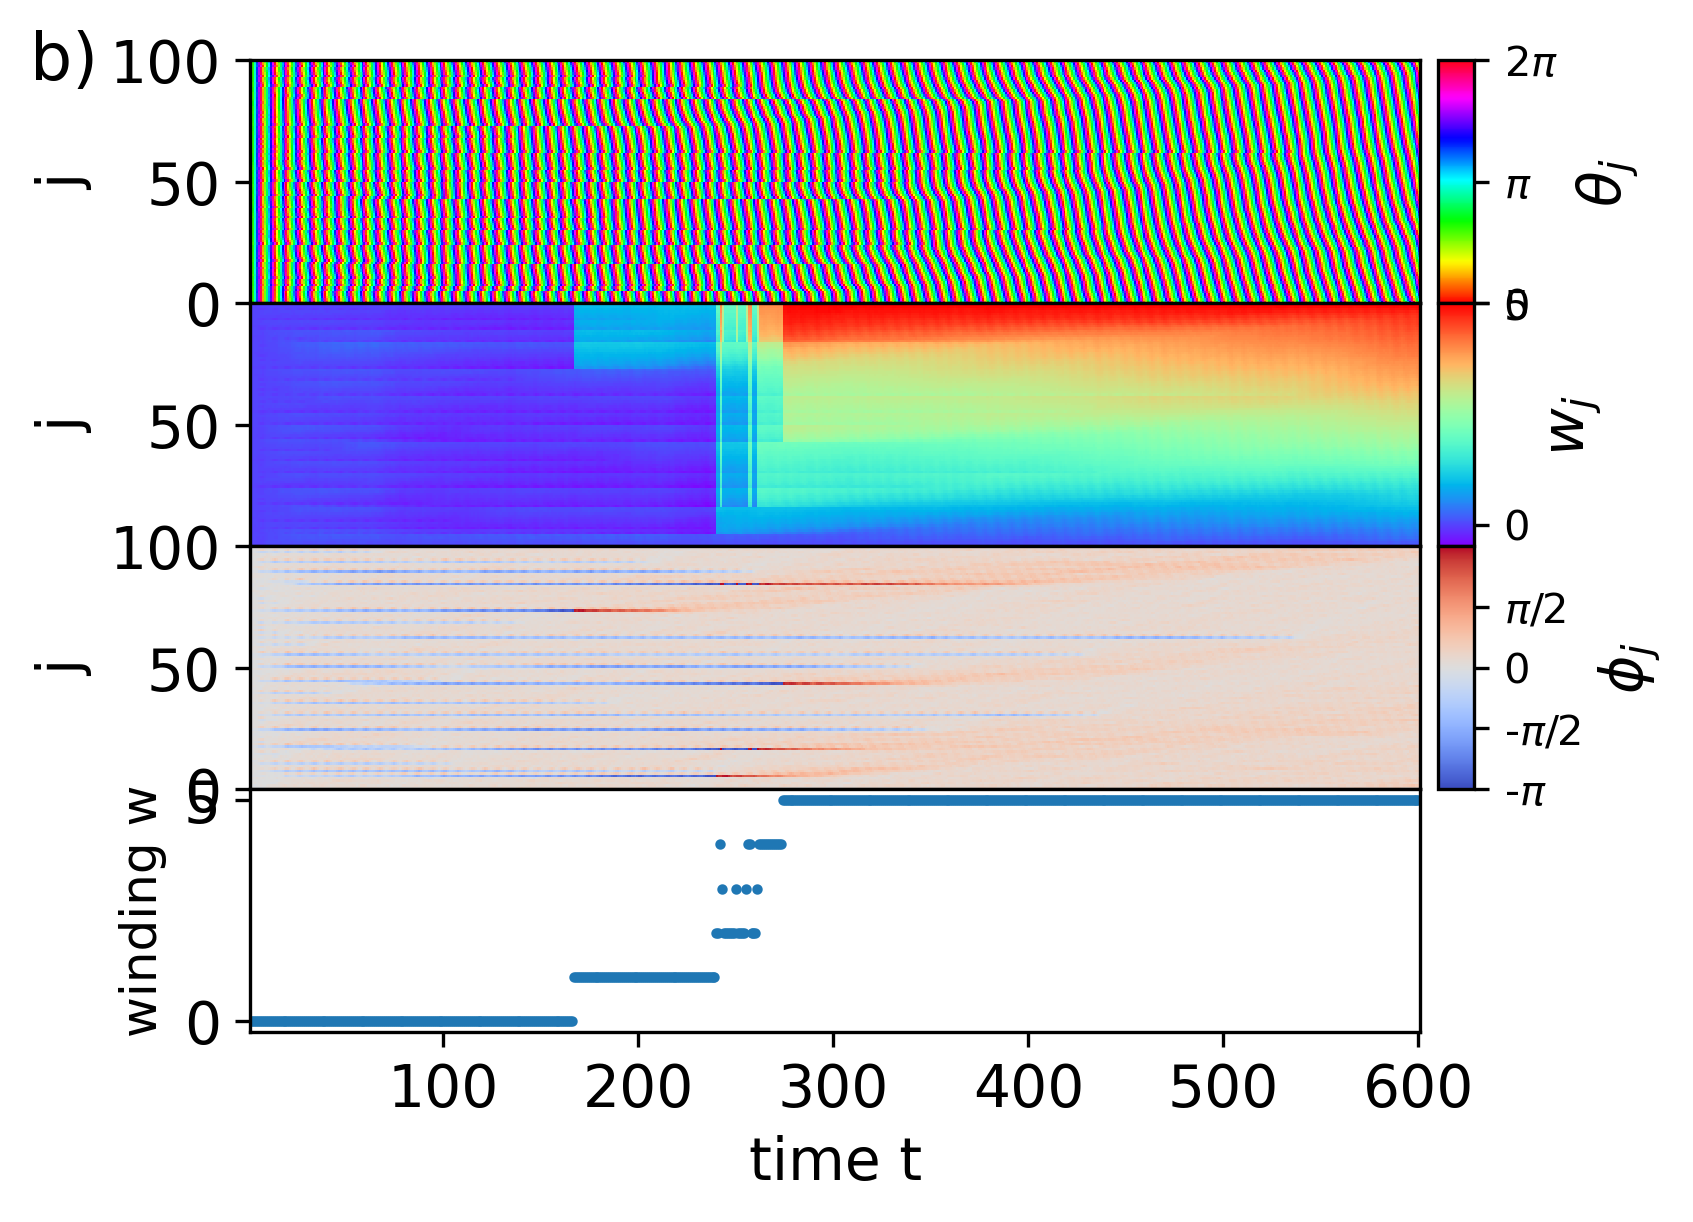

In [371]:
# overlap model + some diffusion , stochastic exploration!
hol=0.05; beta=0.1;  A_c = 0.; A_s = 0.; nu_cp = 0.0; nu_cm = 0.00;
omega0=1.

K_u=0.2;      
nu_p=0.002*10; nu_m=nu_p; 
eta = 1e-4*10  

parms = np.zeros(20)
parms[0] = omega0; parms[1] = K_u;parms[2] = nu_p; parms[3] = nu_m; parms[4] = nu_cp;
parms[5] = nu_cm; parms[6] = beta;  parms[7] = hol; parms[8] = A_c; parms[9] = A_s;

parms[12] = eta # Gaussian white noise! sqrt(dt*eta)*normal distn
dt=0.05
func = du_fun_overlap

# initial conditions, flat
N=50; eta_rand=0*np.pi; slope_ramp = 0.0; 
mag_sin = 0.0; index_sin = 4;  phase_sin = 0.0;  
peak = 0; iroll_ramp = 10
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])

u_arr0 = give_init(N,iparms)
#plt.plot(u_arr0,'.')

ndn=600; dn=20; nsteps=dn
print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)
ofile="OVN2.png"; 
pos=[-112,92]; alabel="b)"
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)
print('winding from', np.rint(winding_number[0]),' to ', np.rint(winding_number[-1]))
phisig_arr = phivar(dudj_arr)

print('phisig at end {:.4f} rad, {:.4f} deg'.format(\
              phisig_arr[-1],phisig_arr[-1]*180/np.pi))

eta/nu_p 1.50
tmax = 601
winding from 0.0  to  13.0
phisig at end 0.6376 rad, 36.5319 deg


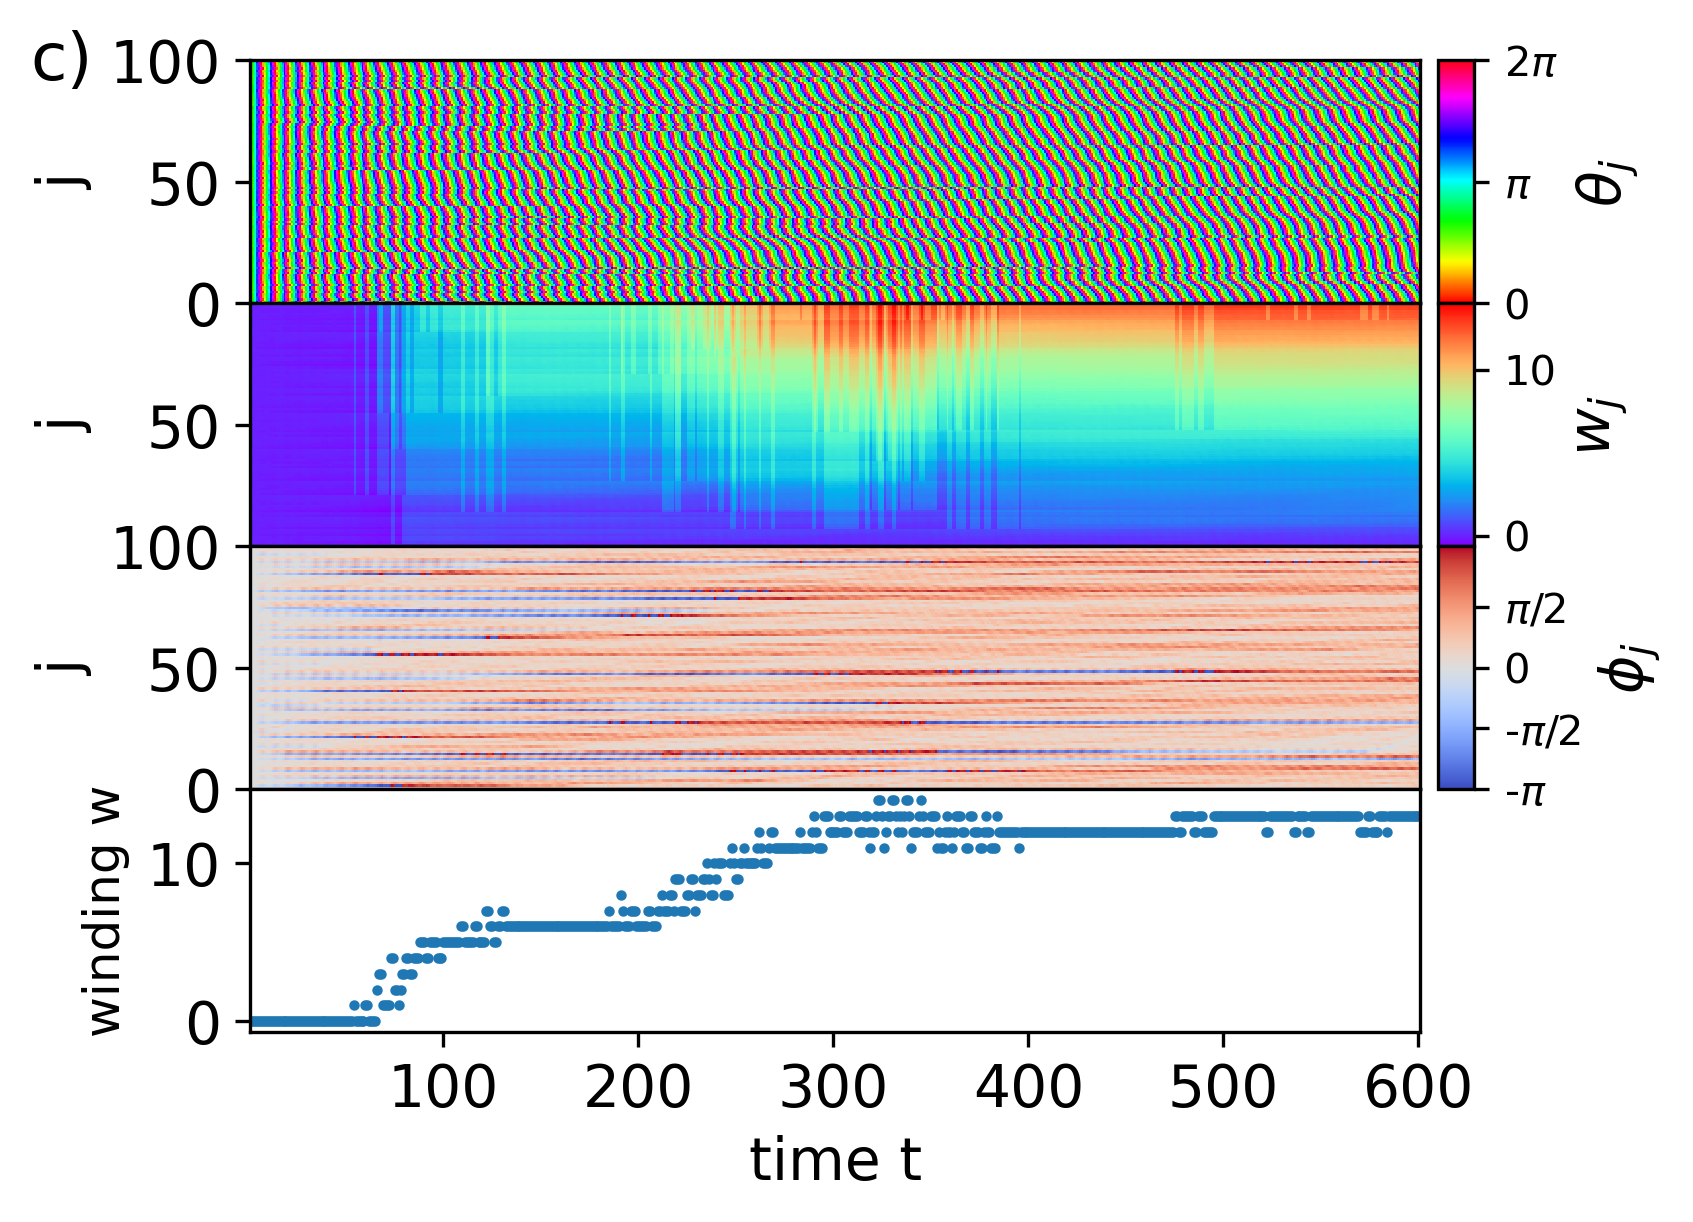

In [374]:
# overlap model + some diffusion , stochastic exploration!
hol=0.05; beta=0.1;  A_c = 0.; A_s = 0.; nu_cp = 0.0; nu_cm = 0.00;
omega0=1.

K_u=0.2;      
nu_p=0.002; nu_m=nu_p; 
eta = 1e-4*30  

parms = np.zeros(20)
parms[0] = omega0; parms[1] = K_u;parms[2] = nu_p; parms[3] = nu_m; parms[4] = nu_cp;
parms[5] = nu_cm; parms[6] = beta;  parms[7] = hol; parms[8] = A_c; parms[9] = A_s;


parms[12] = eta # Gaussian white noise! sqrt(dt*eta)*normal distn
# in the absense of integration and omega theta would be Wiener process
dx = 2*np.pi/N
print('eta/nu_p {:.2f}'.format(eta/nu_p))

dt=0.05
func = du_fun_overlap

# initial conditions, flat
N=100; eta_rand=0*np.pi; slope_ramp = 0.0; 
mag_sin = 0.0; index_sin = 4;  phase_sin = 0.0;  
peak = 0; iroll_ramp = 10
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])

u_arr0 = give_init(N,iparms)
#plt.plot(u_arr0,'.')

ndn=600; dn=20; nsteps=dn
print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)

ofile="OVN3.png"; 
pos=[-112,92]; alabel="c)"
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)
print('winding from', np.rint(winding_number[0]),' to ', np.rint(winding_number[-1]))
phisig_arr = phivar(dudj_arr)

print('phisig at end {:.4f} rad, {:.4f} deg'.format(\
              phisig_arr[-1],phisig_arr[-1]*180/np.pi))

eta/nu_p 0.05
tmax = 601
winding from 0.0  to  5.0
phisig at end 0.1228 rad, 7.0356 deg


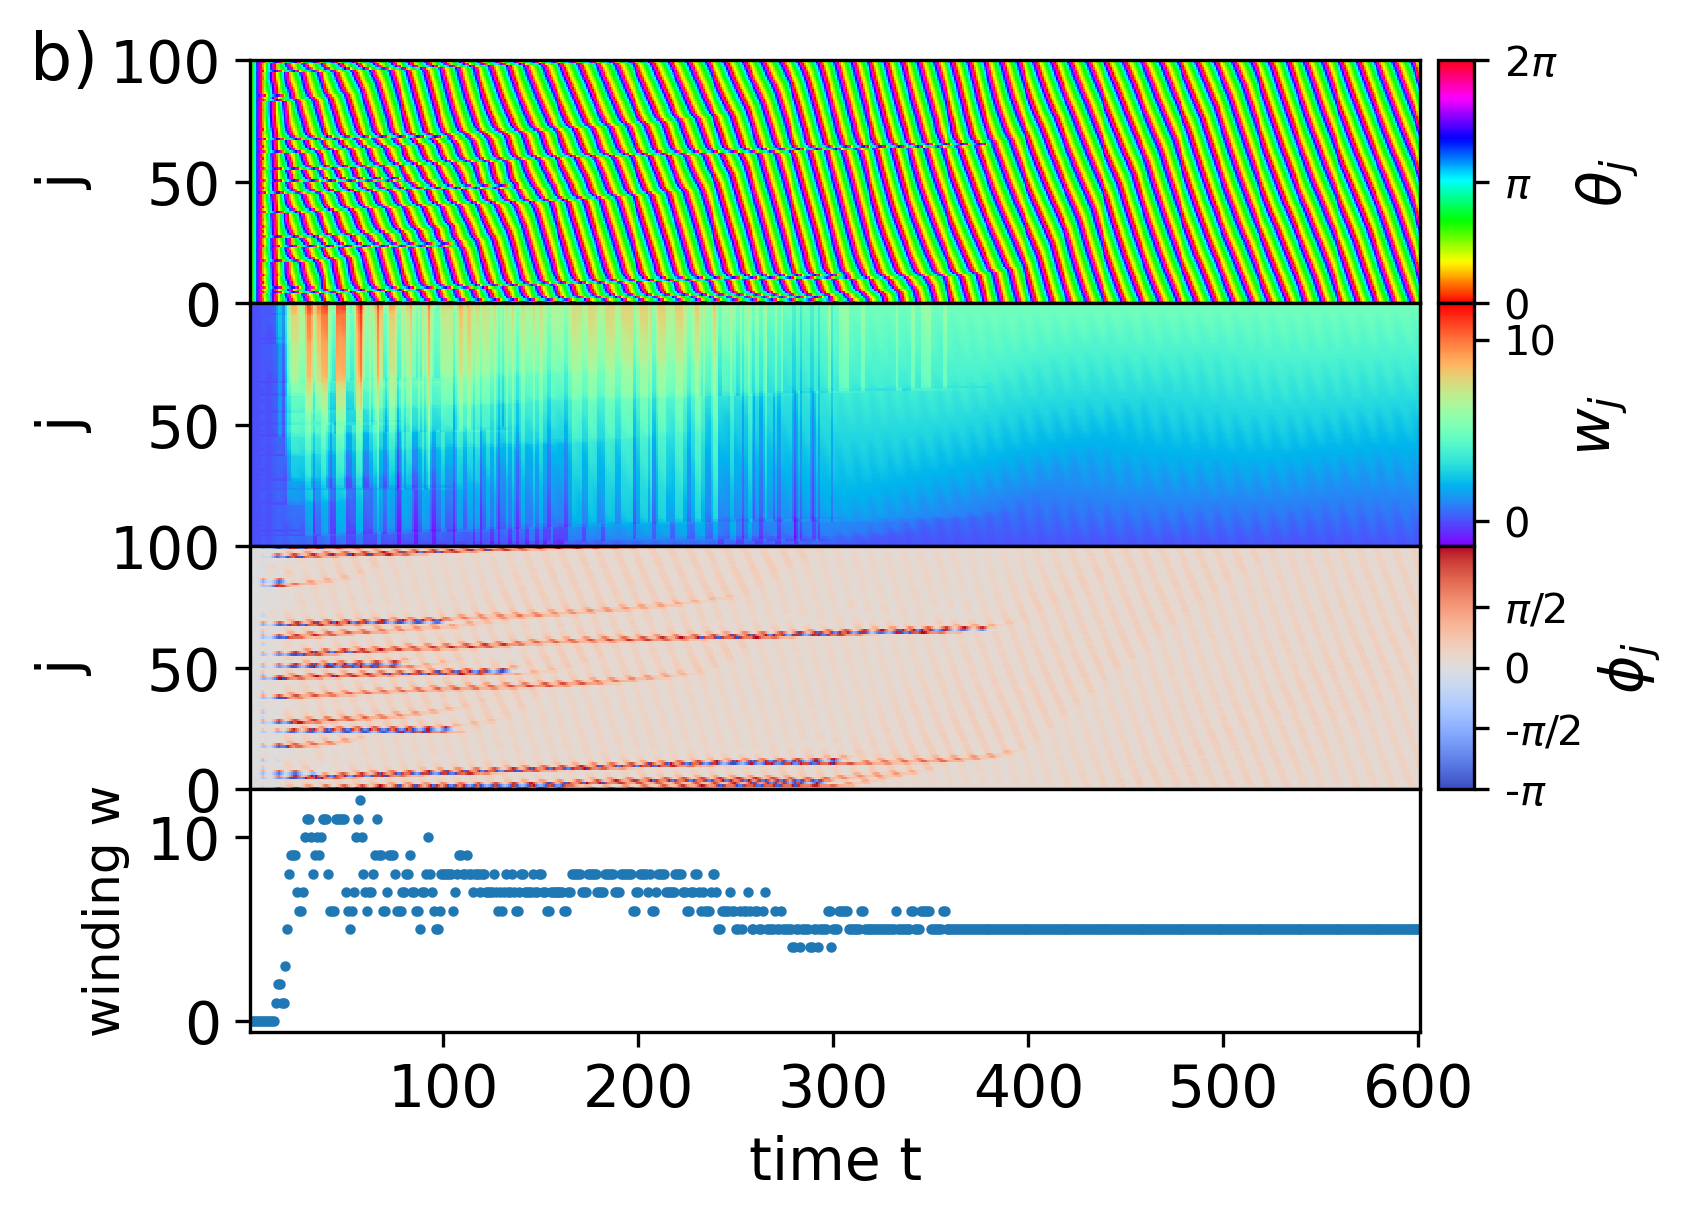

In [367]:
# overlap model + some diffusion , stochastic exploration!
hol=0.05; beta=0.1;  A_c = 0.; A_s = 0.; nu_cp = 0.0; nu_cm = 0.00;
omega0=1.

K_u=0.2*3;      
nu_p=0.002; nu_m=nu_p; 
eta = 1e-4 

parms = np.zeros(20)
parms[0] = omega0; parms[1] = K_u; parms[2] = nu_p; parms[3] = nu_m; parms[4] = nu_cp;
parms[5] = nu_cm; parms[6] = beta; parms[7] = hol; parms[8] = A_c; parms[9] = A_s;

parms[12] = eta # Gaussian white noise! sqrt(dt*eta)*normal distn
# in the absense of integration and omega theta would be Wiener process
dx = 2*np.pi/N
print('eta/nu_p {:.2f}'.format(eta/nu_p))

dt=0.05
func = du_fun_overlap

# initial conditions, flat
N=100; eta_rand=0*np.pi; slope_ramp = 0.0; 
mag_sin = 0.0; index_sin = 4;  phase_sin = 0.0;  
peak = 0; iroll_ramp = 10
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])

u_arr0 = give_init(N,iparms)
#plt.plot(u_arr0,'.')

ndn=600; dn=20; nsteps=dn
print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)

ofile=""; 
pos=[-112,92]; alabel="b)"
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)
print('winding from', np.rint(winding_number[0]),' to ', np.rint(winding_number[-1]))
phisig_arr = phivar(dudj_arr)

print('phisig at end {:.4f} rad, {:.4f} deg'.format(\
              phisig_arr[-1],phisig_arr[-1]*180/np.pi))

eta/nu_p 50.00
tmax = 601
winding from 0.0  to  -0.0
phisig at end 1.6085 rad, 92.1575 deg


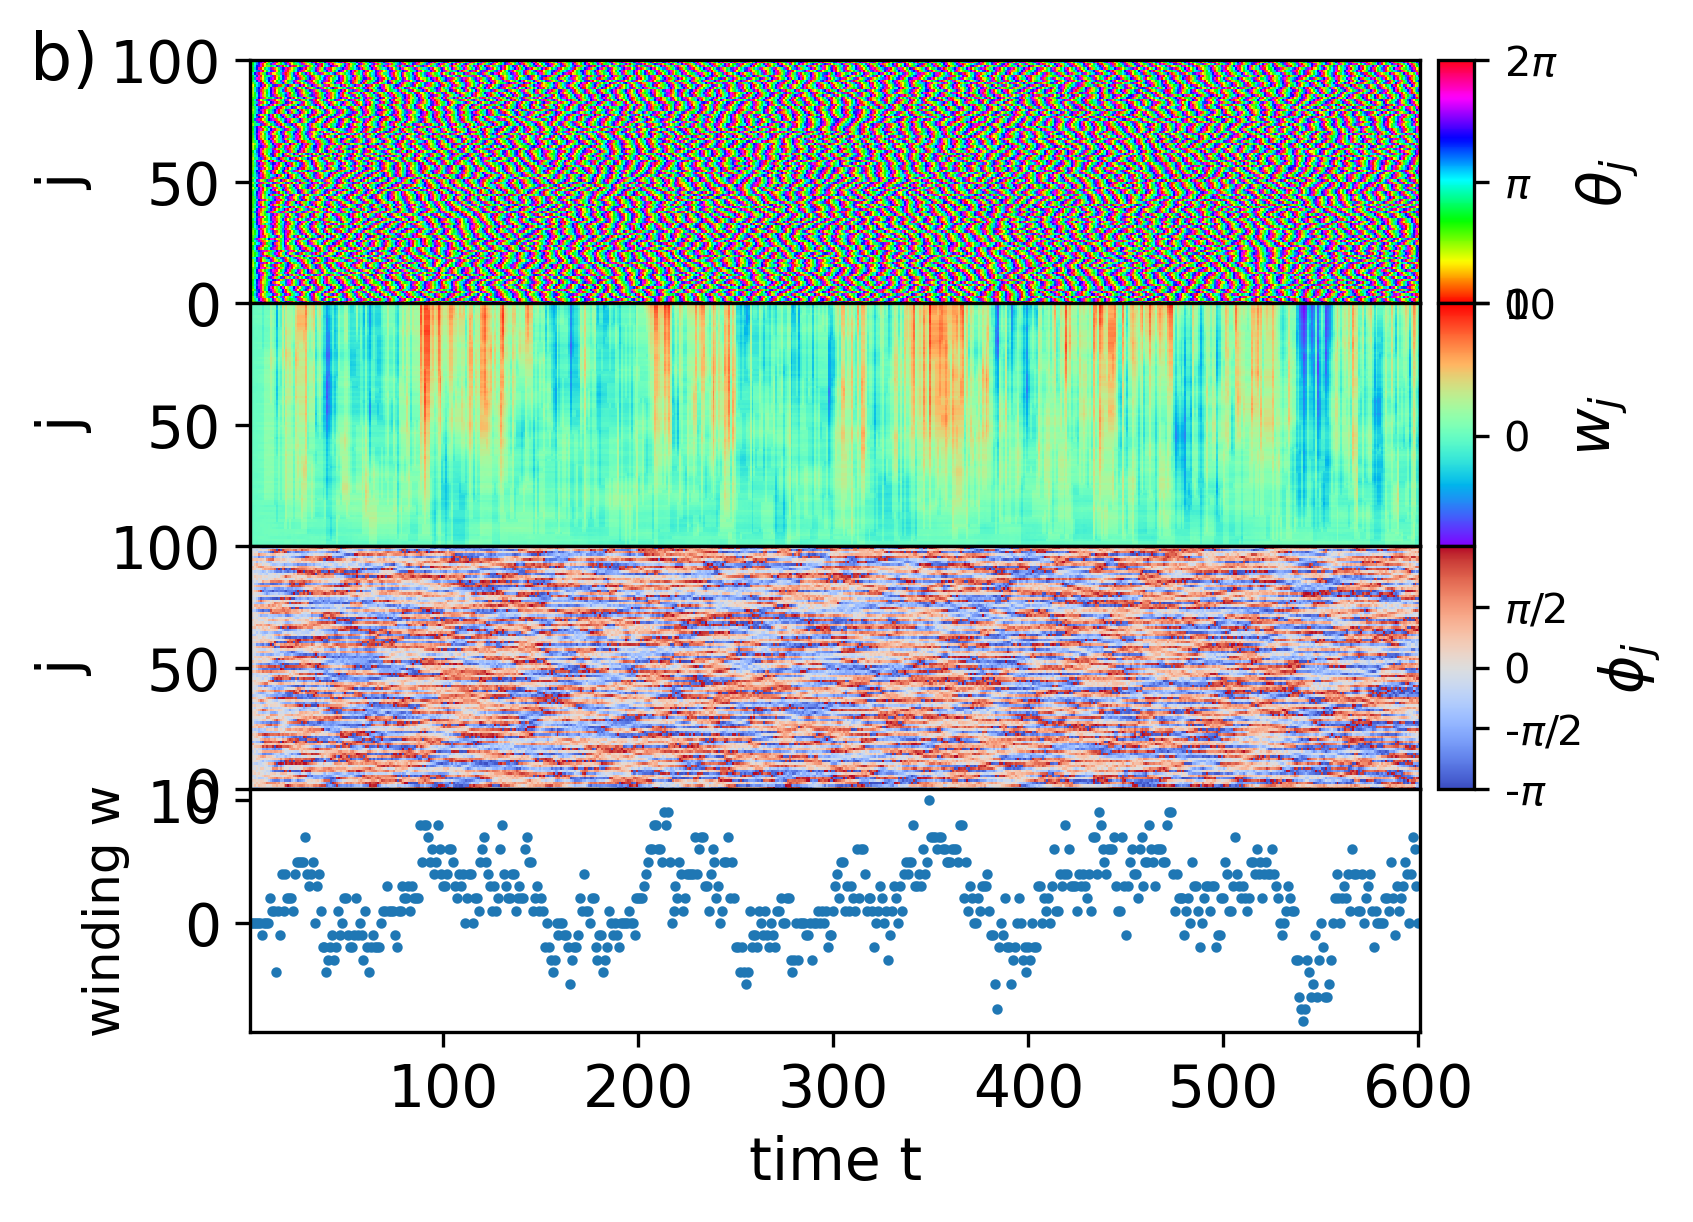

In [434]:
# overlap model + some diffusion , stochastic exploration!
hol=0.05; beta=0.1;  A_c = 0.; A_s = 0.; nu_cp = 0.0; nu_cm = 0.00;
omega0=1.

K_u=0.2;      
nu_p=0.002; nu_m=nu_p; 
eta = 1e-1 

parms = np.zeros(20)
parms[0] = omega0; parms[1] = K_u; parms[2] = nu_p; parms[3] = nu_m; parms[4] = nu_cp;
parms[5] = nu_cm; parms[6] = beta; parms[7] = hol; parms[8] = A_c; parms[9] = A_s;

parms[12] = eta # Gaussian white noise! sqrt(dt*eta)*normal distn
# in the absense of integration and omega theta would be Wiener process
dx = 2*np.pi/N
print('eta/nu_p {:.2f}'.format(eta/nu_p))

dt=0.05
func = du_fun_overlap

# initial conditions, flat
N=100; eta_rand=0*np.pi; slope_ramp = 0.0; 
mag_sin = 0.0; index_sin = 4;  phase_sin = 0.0;  
peak = 0; iroll_ramp = 10
iparms = np.array([eta_rand,slope_ramp, mag_sin, index_sin,phase_sin,peak,iroll_ramp])

u_arr0 = give_init(N,iparms)
#plt.plot(u_arr0,'.')

ndn=600; dn=20; nsteps=dn
print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                            dt,nsteps,dn,ndn,iparms)

ofile=""; 
pos=[-112,92]; alabel="b)"
newphases_a(uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number,dt,nsteps,dn,ndn,\
            ofile,pos,alabel)
print('winding from', np.rint(winding_number[0]),' to ', np.rint(winding_number[-1]))
phisig_arr = phivar(dudj_arr)

print('phisig at end {:.4f} rad, {:.4f} deg'.format(\
              phisig_arr[-1],phisig_arr[-1]*180/np.pi))

In [ ]:
# below reran some stuff with different N

In [10]:
c2a_fac = omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)/hol**2
print(c2a_fac)

27.243737485422603


In [12]:
# loop over noise eta and K for overlap model
def doloop_long_ov(N,beta,hol,Ku,nu_start,eta_start,fac_nu,fac_eta,ni,nj,doit):
    
    dt=0.05
    func = du_fun_overlap
    ndn=1000; dn=20; nsteps=dn
    print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
    parms = np.zeros(20)
    #K=0.7;  
    #hol=0.05; beta=0.1;  
    A_c = 0.; A_s = 0.; 
    omega0=1.0
    nu_cp = 0.0; nu_cm = 0.0;
    #N=64; 
    # initial conditions 
    eta_rand=0*np.pi; slope_ramp = 0.0; 
    peak = 0; iroll_ramp = 10
    index_sin = 4;  
    phase_sin = 0.0;
    mag_sin = 0.;
    c2a = Ku*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)/hol**2
    print('c2a = {:.5f}'.format(c2a))
    
    #ni = 15; nj = 10
    nu_arr = np.zeros((ni,nj))
    w_arr = np.zeros((ni,nj))
    eta_arr = np.zeros((ni,nj))
    p_arr = np.zeros((ni,nj))
    winding_number = np.zeros(10)
    #half_ni = int(ni/2)
    for i in range(ni):
        nu_p = nu_start * np.power(fac_nu,i);
        nu_m = nu_p
        for j in range(nj):
            nu_arr[i,j] = nu_p
            eta = eta_start * np.power(fac_eta,j)
            eta_arr[i,j] = eta
            # lopsided niedermayer model with noise
            parms[0] = omega0
            parms[1] = Ku
            parms[2] = nu_p
            parms[3] = nu_m
            parms[4] = nu_cp
            parms[5] = nu_cm
            parms[6] = beta
            parms[7] = hol
            parms[8] = A_c
            parms[9] = A_s
            parms[12] = eta

            # initial conditions 
            iparms = np.array([eta_rand,slope_ramp, mag_sin, \
                               index_sin,phase_sin,peak,iroll_ramp])
            
            u_arr0 = give_init(N,iparms)
            
            if (doit==1):
                uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                           dt,nsteps,dn,ndn,iparms)
            
            fac1 =0; fac2=0
            if (nu_p >0):
                fac1 = 0.5*eta/nu_p
                fac2 = 0.5*c2a/nu_p
            
            print('eta={:.4f}, nu={:.4f}, eta/nu2={:.4f}, c2a/nu2={:.4f}, '.format(\
                eta,nu_p,fac1,fac2),\
                'w from {:.0f} to {:.0f}'.format(np.rint(winding_number[0])
                                                ,np.rint(winding_number[-1])))
            if (doit==1):
                w_arr[i,j] = np.rint(winding_number[-1])
                phisig_arr = phivar(dudj_arr)
                p_arr[i,j] = phisig_arr[-1]
        
    return nu_arr,eta_arr,w_arr,p_arr

N=50
nu_start = 0.0006;
eta_start = 0.0001;
fac_nu = 1.5
fac_eta =1.5
ni = 16; nj = 16  #ni for nu_p loop
K_u3=0.3; hol=0.05; beta=0.1;  
nu_arr3,eta_arr3,w_arr3,p_arr3 = \
    doloop_long_ov(N,beta,hol,K_u,nu_start,eta_start,fac_nu,fac_eta,ni,nj,1)

#eta=0.04, nu=0.26,

tmax = 1001
c2a = 13.62187
eta=0.0001, nu=0.0006, eta/nu2=0.0833, c2a/nu2=11351.5573,  w from 0 to 3
eta=0.0002, nu=0.0006, eta/nu2=0.1250, c2a/nu2=11351.5573,  w from 0 to 3
eta=0.0002, nu=0.0006, eta/nu2=0.1875, c2a/nu2=11351.5573,  w from 0 to 3
eta=0.0003, nu=0.0006, eta/nu2=0.2813, c2a/nu2=11351.5573,  w from 0 to 3
eta=0.0005, nu=0.0006, eta/nu2=0.4219, c2a/nu2=11351.5573,  w from 0 to 3
eta=0.0008, nu=0.0006, eta/nu2=0.6328, c2a/nu2=11351.5573,  w from 0 to 3
eta=0.0011, nu=0.0006, eta/nu2=0.9492, c2a/nu2=11351.5573,  w from 0 to 3
eta=0.0017, nu=0.0006, eta/nu2=1.4238, c2a/nu2=11351.5573,  w from 0 to 4
eta=0.0026, nu=0.0006, eta/nu2=2.1357, c2a/nu2=11351.5573,  w from 0 to 3
eta=0.0038, nu=0.0006, eta/nu2=3.2036, c2a/nu2=11351.5573,  w from 0 to 3
eta=0.0058, nu=0.0006, eta/nu2=4.8054, c2a/nu2=11351.5573,  w from 0 to 3
eta=0.0086, nu=0.0006, eta/nu2=7.2081, c2a/nu2=11351.5573,  w from 0 to 5
eta=0.0130, nu=0.0006, eta/nu2=10.8122, c2a/nu2=11351.5573,  w from 0 to 5
eta=0.0195

eta=0.0001, nu=0.0103, eta/nu2=0.0049, c2a/nu2=664.3801,  w from 0 to 3
eta=0.0002, nu=0.0103, eta/nu2=0.0073, c2a/nu2=664.3801,  w from 0 to 3
eta=0.0002, nu=0.0103, eta/nu2=0.0110, c2a/nu2=664.3801,  w from 0 to 3
eta=0.0003, nu=0.0103, eta/nu2=0.0165, c2a/nu2=664.3801,  w from 0 to 3
eta=0.0005, nu=0.0103, eta/nu2=0.0247, c2a/nu2=664.3801,  w from 0 to 3
eta=0.0008, nu=0.0103, eta/nu2=0.0370, c2a/nu2=664.3801,  w from 0 to 4
eta=0.0011, nu=0.0103, eta/nu2=0.0556, c2a/nu2=664.3801,  w from 0 to 3
eta=0.0017, nu=0.0103, eta/nu2=0.0833, c2a/nu2=664.3801,  w from 0 to 3
eta=0.0026, nu=0.0103, eta/nu2=0.1250, c2a/nu2=664.3801,  w from 0 to 3
eta=0.0038, nu=0.0103, eta/nu2=0.1875, c2a/nu2=664.3801,  w from 0 to 4
eta=0.0058, nu=0.0103, eta/nu2=0.2813, c2a/nu2=664.3801,  w from 0 to 4
eta=0.0086, nu=0.0103, eta/nu2=0.4219, c2a/nu2=664.3801,  w from 0 to 4
eta=0.0130, nu=0.0103, eta/nu2=0.6328, c2a/nu2=664.3801,  w from 0 to 4
eta=0.0195, nu=0.0103, eta/nu2=0.9492, c2a/nu2=664.3801,  w from

eta=0.0003, nu=0.1752, eta/nu2=0.0010, c2a/nu2=38.8846,  w from 0 to 0
eta=0.0005, nu=0.1752, eta/nu2=0.0014, c2a/nu2=38.8846,  w from 0 to 0
eta=0.0008, nu=0.1752, eta/nu2=0.0022, c2a/nu2=38.8846,  w from 0 to 0
eta=0.0011, nu=0.1752, eta/nu2=0.0033, c2a/nu2=38.8846,  w from 0 to 0
eta=0.0017, nu=0.1752, eta/nu2=0.0049, c2a/nu2=38.8846,  w from 0 to 0
eta=0.0026, nu=0.1752, eta/nu2=0.0073, c2a/nu2=38.8846,  w from 0 to 0
eta=0.0038, nu=0.1752, eta/nu2=0.0110, c2a/nu2=38.8846,  w from 0 to -0
eta=0.0058, nu=0.1752, eta/nu2=0.0165, c2a/nu2=38.8846,  w from 0 to -0
eta=0.0086, nu=0.1752, eta/nu2=0.0247, c2a/nu2=38.8846,  w from 0 to 0
eta=0.0130, nu=0.1752, eta/nu2=0.0370, c2a/nu2=38.8846,  w from 0 to 0
eta=0.0195, nu=0.1752, eta/nu2=0.0556, c2a/nu2=38.8846,  w from 0 to -0
eta=0.0292, nu=0.1752, eta/nu2=0.0833, c2a/nu2=38.8846,  w from 0 to 0
eta=0.0438, nu=0.1752, eta/nu2=0.1250, c2a/nu2=38.8846,  w from 0 to -0
eta=0.0001, nu=0.2627, eta/nu2=0.0002, c2a/nu2=25.9231,  w from 0 to 0
et

c2a = 8.17312
0.0006 0.2627363342285156
0.0001 0.04378938903808594


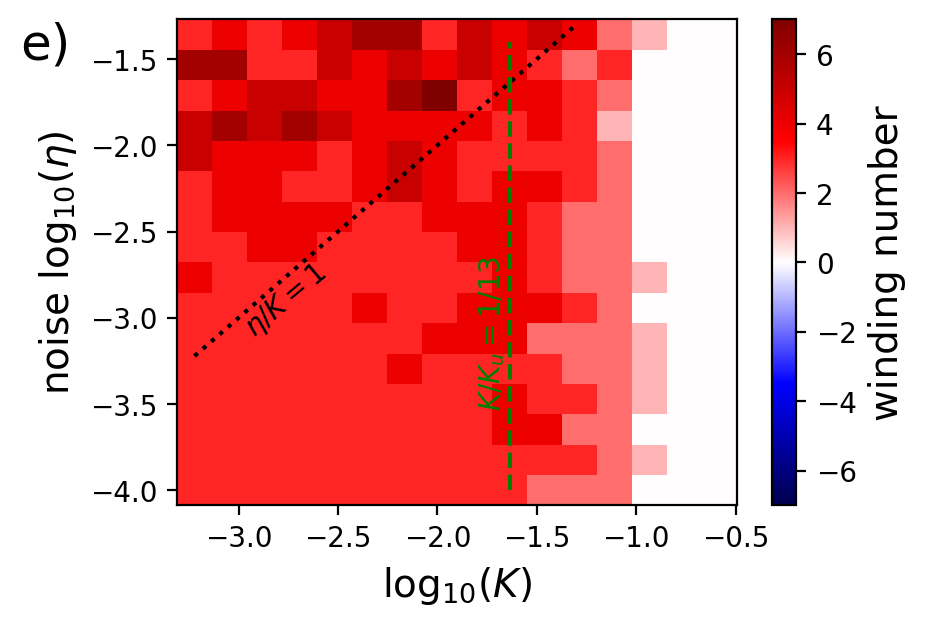

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.18,right=0.88,bottom=0.17,top=0.98)
c2a = K_u3*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)/hol**2
print('c2a = {:.5f}'.format(c2a))
#nuratio = np.log10(0.5*c2a/nu_arr3)
#etaratio = np.log10(0.5*eta_arr3/nu_arr3)
wmax = np.max(w_arr3)
im=ax.pcolormesh(np.log10(nu_arr3),np.log10(eta_arr3),w_arr3,cmap='seismic',
                vmin=-wmax,vmax=wmax)  
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'$\log_{10}(K)$',fontsize=14)
cbar = plt.colorbar(im)
cbar.set_label('winding number',fontsize=14)

xlin = np.linspace(np.min(np.log10(nu_arr3)), -1.3,10)
ylin = xlin
ax.plot(xlin,ylin,'k:')
ax.text(-3.0,-3.1,r'$\eta/K=1$',rotation=40)
ylin = np.linspace(-4,-1.4,10)
xlin = 0*ylin + np.log10(K_u3/13)  # K=Ku/13
ax.plot(xlin,ylin,'g--')
ax.text(-1.8,-3.5,r'$K/K_u=1/13$',rotation=90,color='green')

ax.text(-4.1,-1.5,'e)',fontsize=18)
plt.savefig('ov_noise_mm.png',dpi=300)
print(np.min(nu_arr3),np.max(nu_arr3))
print(np.min(eta_arr3),np.max(eta_arr3))

c2a = 8.17312
0.0006 0.2627363342285156
0.0001 0.04378938903808594


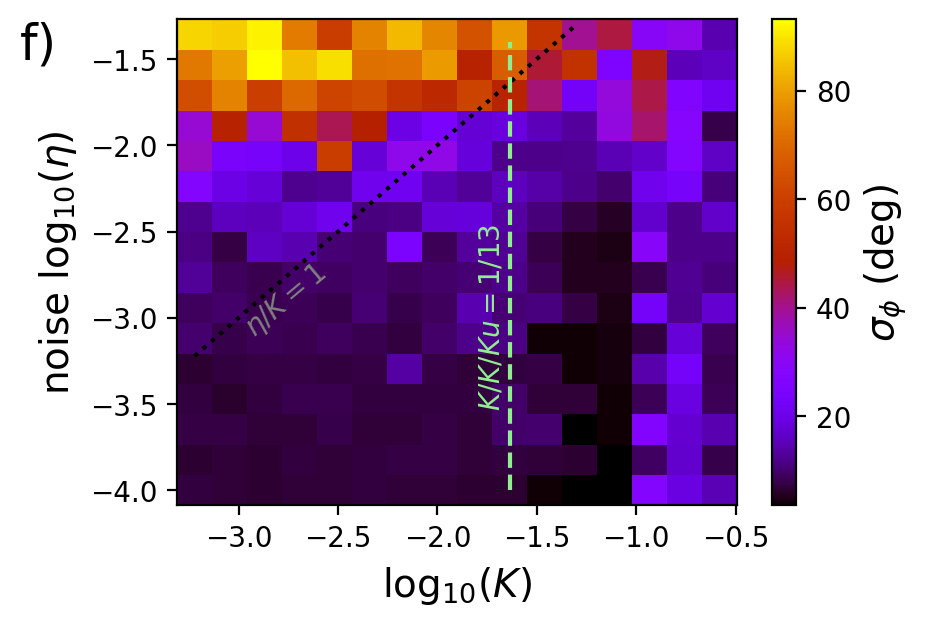

In [22]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.18,right=0.88,bottom=0.17,top=0.98)
c2a = K_u3*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)/hol**2
print('c2a = {:.5f}'.format(c2a))
nuratio = np.log10(0.5*c2a/nu_arr3)
etaratio = np.log10(0.5*eta_arr3/nu_arr3)
#im=ax.pcolormesh(nu_arr3,eta_arr3,w_arr3,cmap='jet')  
im=ax.pcolormesh(np.log10(nu_arr3),np.log10(eta_arr3),\
                 p_arr3*180/np.pi,cmap='gnuplot')  
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'$\log_{10}(K)$',fontsize=14)
cbar = plt.colorbar(im)

cbar.set_label(r'$\sigma_\phi$ (deg)',fontsize=14)
ax.text(-4.1,-1.5,'f)',fontsize=18)
xlin = np.linspace(np.min(np.log10(nu_arr3)), -1.3,10)
ylin = xlin
ax.plot(xlin,ylin,'k:')
ax.text(-3.0,-3.1,r'$\eta/K=1$',rotation=40,color='grey')
ylin = np.linspace(-4,-1.4,10)
xlin = 0*ylin + np.log10(K_u3/13)
ax.plot(xlin,ylin,'--',color='lightgreen')
ax.text(-1.8,-3.5,r'$K/K_u=1/13$',rotation=90,color='lightgreen')

plt.savefig('ov_noise_sig_mm.png',dpi=300)
print(np.min(nu_arr3),np.max(nu_arr3))
print(np.min(eta_arr3),np.max(eta_arr3))

In [30]:
# loop over noise eta and K_u for overlap model
def doloop_long_ov2(N,beta,hol,nu,Ku_start,eta_start,fac_Ku,fac_eta,ni,nj,doit):
    
    dt=0.05
    func = du_fun_overlap
    ndn=1000; dn=20; nsteps=dn
    print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
    parms = np.zeros(20)

    #hol=0.05; beta=0.1;  
    A_c = 0.; A_s = 0.; 
    omega0=1.0
    nu_cp = 0.0; nu_cm = 0.0;
    nu_p = nu; 
    nu_m = nu_p
    #N=64; 
    # initial conditions 
    eta_rand=0*np.pi; slope_ramp = 0.0; 
    peak = 0; iroll_ramp = 10
    index_sin = 4;  
    phase_sin = 0.0;
    mag_sin = 0.;
    #c2a = K*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)
    #print('c2a = {:.5f}'.format(c2a))
    
    Ku_arr = np.zeros((ni,nj))
    w_arr = np.zeros((ni,nj))
    eta_arr = np.zeros((ni,nj))
    p_arr = np.zeros((ni,nj))
    winding_number = np.zeros(10)

    for i in range(ni):
        Ku = Ku_start * np.power(fac_Ku,i);
        for j in range(nj):
            Ku_arr[i,j] = Ku
            eta = eta_start * np.power(fac_eta,j)
            eta_arr[i,j] = eta
            # lopsided niedermayer model with noise
            parms[0] = omega0
            parms[1] = Ku
            parms[2] = nu_p
            parms[3] = nu_m
            parms[4] = nu_cp
            parms[5] = nu_cm
            parms[6] = beta
            parms[7] = hol
            parms[8] = A_c
            parms[9] = A_s
            parms[12] = eta

            # initial conditions 
            iparms = np.array([eta_rand,slope_ramp, mag_sin, \
                               index_sin,phase_sin,peak,iroll_ramp])
            
            u_arr0 = give_init(N,iparms)
            
            if (doit==1):
                uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                           dt,nsteps,dn,ndn,iparms)
            
            
            c2a = Ku*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)/hol**2
            fac1 =0; fac2=0
            if (nu_p >0):
                fac1 = 0.5*eta/nu_p
                fac2 = 0.5*c2a/nu_p
            
            print('eta={:.4f}, Ku={:.4f}, eta/nu2={:.4f}, c2a/nu2={:.4f}, '.format(\
                eta,Ku,fac1,fac2),\
                'w from {:.0f} to {:.0f}'.format(np.rint(winding_number[0])
                                                ,np.rint(winding_number[-1])))
            if (doit==1):
                w_arr[i,j] = np.rint(winding_number[-1])
                phisig_arr = phivar(dudj_arr)
                p_arr[i,j] = phisig_arr[-1]
        
    return Ku_arr,eta_arr,w_arr,p_arr

N=100
Ku_start = 0.01;
eta_start = 0.0001;
fac_Ku = 1.25
fac_eta =1.5
ni = 16; nj = 16  #ni for Ku loop
nu4=0.002; hol=0.05; beta=0.1;  
Ku_arr4,eta_arr4,w_arr4,p_arr4 = \
    doloop_long_ov2(N,beta,hol,nu4,Ku_start,eta_start,fac_Ku,fac_eta,ni,nj,1)



tmax = 1001
eta=0.0001, Ku=0.0100, eta/nu2=0.0250, c2a/nu2=68.1093,  w from 0 to 0
eta=0.0002, Ku=0.0100, eta/nu2=0.0375, c2a/nu2=68.1093,  w from 0 to 0
eta=0.0002, Ku=0.0100, eta/nu2=0.0563, c2a/nu2=68.1093,  w from 0 to 0
eta=0.0003, Ku=0.0100, eta/nu2=0.0844, c2a/nu2=68.1093,  w from 0 to 0
eta=0.0005, Ku=0.0100, eta/nu2=0.1266, c2a/nu2=68.1093,  w from 0 to 0
eta=0.0008, Ku=0.0100, eta/nu2=0.1898, c2a/nu2=68.1093,  w from 0 to 0
eta=0.0011, Ku=0.0100, eta/nu2=0.2848, c2a/nu2=68.1093,  w from 0 to 0
eta=0.0017, Ku=0.0100, eta/nu2=0.4271, c2a/nu2=68.1093,  w from 0 to 1
eta=0.0026, Ku=0.0100, eta/nu2=0.6407, c2a/nu2=68.1093,  w from 0 to 0
eta=0.0038, Ku=0.0100, eta/nu2=0.9611, c2a/nu2=68.1093,  w from 0 to -1
eta=0.0058, Ku=0.0100, eta/nu2=1.4416, c2a/nu2=68.1093,  w from 0 to 2
eta=0.0086, Ku=0.0100, eta/nu2=2.1624, c2a/nu2=68.1093,  w from 0 to 1
eta=0.0130, Ku=0.0100, eta/nu2=3.2437, c2a/nu2=68.1093,  w from -0 to -1
eta=0.0195, Ku=0.0100, eta/nu2=4.8655, c2a/nu2=68.1093,  w fro

eta=0.0002, Ku=0.0477, eta/nu2=0.0563, c2a/nu2=324.7707,  w from 0 to 4
eta=0.0003, Ku=0.0477, eta/nu2=0.0844, c2a/nu2=324.7707,  w from 0 to 5
eta=0.0005, Ku=0.0477, eta/nu2=0.1266, c2a/nu2=324.7707,  w from 0 to 6
eta=0.0008, Ku=0.0477, eta/nu2=0.1898, c2a/nu2=324.7707,  w from 0 to 6
eta=0.0011, Ku=0.0477, eta/nu2=0.2848, c2a/nu2=324.7707,  w from 0 to 8
eta=0.0017, Ku=0.0477, eta/nu2=0.4271, c2a/nu2=324.7707,  w from 0 to 10
eta=0.0026, Ku=0.0477, eta/nu2=0.6407, c2a/nu2=324.7707,  w from 0 to 8
eta=0.0038, Ku=0.0477, eta/nu2=0.9611, c2a/nu2=324.7707,  w from 0 to 8
eta=0.0058, Ku=0.0477, eta/nu2=1.4416, c2a/nu2=324.7707,  w from 0 to 12
eta=0.0086, Ku=0.0477, eta/nu2=2.1624, c2a/nu2=324.7707,  w from 0 to 3
eta=0.0130, Ku=0.0477, eta/nu2=3.2437, c2a/nu2=324.7707,  w from 0 to 6
eta=0.0195, Ku=0.0477, eta/nu2=4.8655, c2a/nu2=324.7707,  w from 0 to 6
eta=0.0292, Ku=0.0477, eta/nu2=7.2982, c2a/nu2=324.7707,  w from 0 to 4
eta=0.0438, Ku=0.0477, eta/nu2=10.9473, c2a/nu2=324.7707,  w f

eta=0.0003, Ku=0.2274, eta/nu2=0.0844, c2a/nu2=1548.6272,  w from 0 to 11
eta=0.0005, Ku=0.2274, eta/nu2=0.1266, c2a/nu2=1548.6272,  w from 0 to 12
eta=0.0008, Ku=0.2274, eta/nu2=0.1898, c2a/nu2=1548.6272,  w from 0 to 11
eta=0.0011, Ku=0.2274, eta/nu2=0.2848, c2a/nu2=1548.6272,  w from 0 to 12
eta=0.0017, Ku=0.2274, eta/nu2=0.4271, c2a/nu2=1548.6272,  w from 0 to 12
eta=0.0026, Ku=0.2274, eta/nu2=0.6407, c2a/nu2=1548.6272,  w from 0 to 12
eta=0.0038, Ku=0.2274, eta/nu2=0.9611, c2a/nu2=1548.6272,  w from 0 to 10
eta=0.0058, Ku=0.2274, eta/nu2=1.4416, c2a/nu2=1548.6272,  w from 0 to 10
eta=0.0086, Ku=0.2274, eta/nu2=2.1624, c2a/nu2=1548.6272,  w from 0 to 14
eta=0.0130, Ku=0.2274, eta/nu2=3.2437, c2a/nu2=1548.6272,  w from 0 to 13
eta=0.0195, Ku=0.2274, eta/nu2=4.8655, c2a/nu2=1548.6272,  w from -0 to 6
eta=0.0292, Ku=0.2274, eta/nu2=7.2982, c2a/nu2=1548.6272,  w from 0 to 9
eta=0.0438, Ku=0.2274, eta/nu2=10.9473, c2a/nu2=1548.6272,  w from 0 to 6
eta=0.0001, Ku=0.2842, eta/nu2=0.0250, 

0.01 0.2842170943040401
0.0001 0.04378938903808594


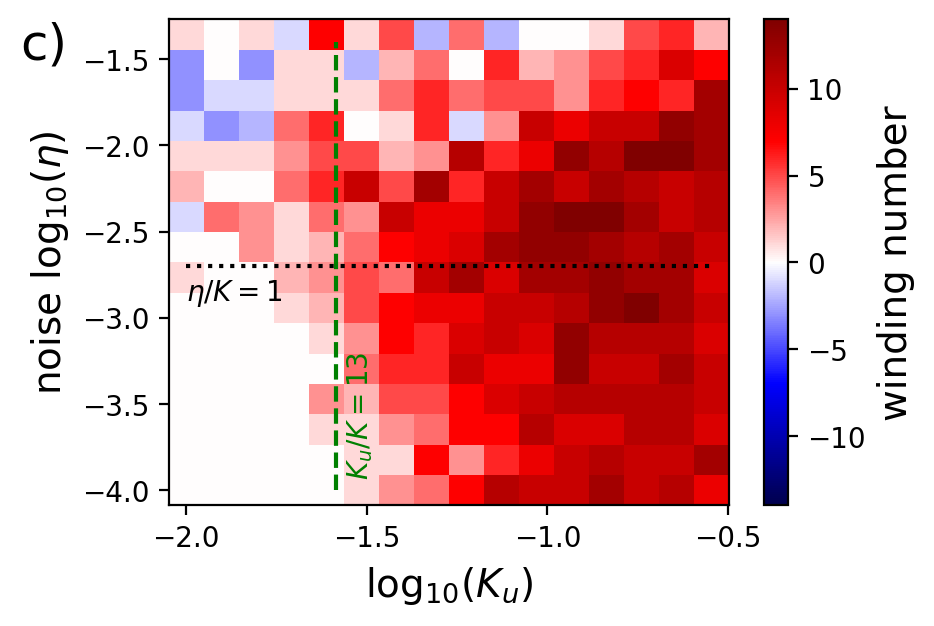

In [32]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.18,right=0.88,bottom=0.17,top=0.98)
c2a = Ku_arr4*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)/hol**2
#print('c2a = {:.5f}'.format(c2a))
Kuratio = np.log10(0.5*c2a/nu4)
etaratio = np.log10(0.5*eta_arr4/nu4)
#im=ax.pcolormesh(Kuratio,etaratio,w_arr4,cmap='jet')  #seismic
im=ax.pcolormesh(np.log10(Ku_arr4),np.log10(eta_arr4),w_arr4,cmap='seismic',\
                vmin=-14,vmax=14)  #seismic
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'$\log_{10}(K_u)$',fontsize=14)
cbar = plt.colorbar(im)
#ax.plot([0.03/fac],[0.02/fac],'h',color='yellow')
#ax.plot([-0.06/fac],[0.005/fac],'d',color='lightgreen')
cbar.set_label('winding number',fontsize=14)
#cbar.set_label(r'$\sigma_\phi$ (deg)',fontsize=14)

# is ov1 K_u=0.2;       nu_p=0.002; nu_m=nu_p; eta = 1e-4  # noise
#ax.plot([np.log10(0.2)],[np.log10(1e-4)],'ko',ms=6) #'OVN1' simulation
#ax.plot([np.log10(0.2)],[np.log10(1e-4)],'wo',ms=2)
xlin = np.linspace(np.min(np.log10(Ku_arr4)), np.max(np.log10(Ku_arr4)),10)
ylin = np.log10(nu4) + 0*xlin
ax.plot(xlin,ylin,'k:',label=r'$\eta/K=1$')
#ax.legend(loc='lower left',borderaxespad=0.1,framealpha=0,labelspacing=0.1,\
#          handlelength=1,handletextpad=0.5)
ax.text(-2,-2.9,r'$\eta/K=1$')

ylin2=np.linspace(-4,-1.4,3)
xlin2=ylin2*0 + np.log10(13*nu4)
ax.plot(xlin2,ylin2,'g--')
ax.text(-1.56,-3.9,r'$K_u/K=13$',rotation=90,color='green')

ax.text(-2.46,-1.5,'c)',fontsize=18)
plt.savefig('ov_noise2b_mm.png',dpi=300)

print(np.min(Ku_arr4),np.max(Ku_arr4))
print(np.min(eta_arr4),np.max(eta_arr4))

In [520]:
c2a_fac = omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)/hol**2
print(c2a_fac)
print(c2a_fac*0.01/(2*nu4))

27.243737485422603
68.10934371355651


0.01 0.2842170943040401
0.0001 0.04378938903808594


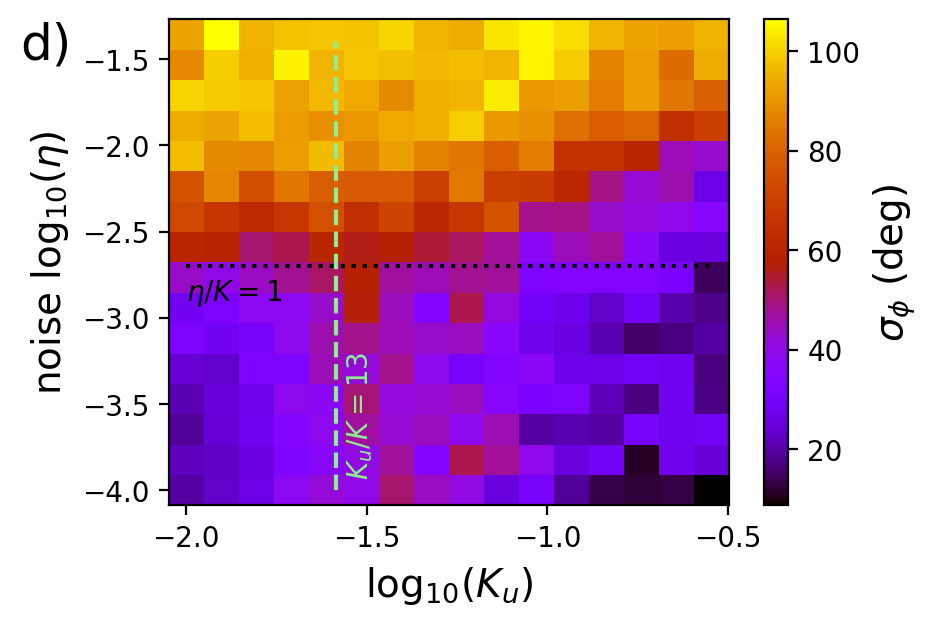

In [33]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.18,right=0.88,bottom=0.17,top=0.98)
#c2a = Ku_arr4*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)/hol**2
#print('c2a = {:.5f}'.format(c2a))
#Kuratio = np.log10(0.5*c2a/nu4)
#etaratio = np.log10(0.5*eta_arr4/nu4)
#im=ax.pcolormesh(Kuratio,etaratio,w_arr4,cmap='jet')  #seismic
im=ax.pcolormesh(np.log10(Ku_arr4),np.log10(eta_arr4),\
                 p_arr4*180/np.pi,cmap='gnuplot')  
ax.set_ylabel(r'noise $\log_{10}(\eta)$',fontsize=14)
ax.set_xlabel(r'$\log_{10}(K_u)$',fontsize=14)
cbar = plt.colorbar(im)
#ax.plot([0.03/fac],[0.02/fac],'h',color='yellow')
#ax.plot([-0.06/fac],[0.005/fac],'d',color='lightgreen')
#cbar.set_label('winding number',fontsize=14)
cbar.set_label(r'$\sigma_\phi$ (deg)',fontsize=14)
# is ov1 K_u=0.2;       nu_p=0.002; nu_m=nu_p; eta = 1e-4  # noise
#ax.plot([np.log10(0.2)],[np.log10(1e-4)],'ko',ms=6) #'OVN1' simulation
#ax.plot([np.log10(0.2)],[np.log10(1e-4)],'wo',ms=2)

xlin = np.linspace(np.min(np.log10(Ku_arr4)), np.max(np.log10(Ku_arr4)),10)
ylin = np.log10(nu4) + 0*xlin
ax.plot(xlin,ylin,'k:',label=r'$\eta/K=1$')
ax.text(-2,-2.9,r'$\eta/K=1$')

ylin2=np.linspace(-4,-1.4,3)
xlin2=ylin2*0 + np.log10(13*nu4)  #K_u=13nu
ax.plot(xlin2,ylin2,'--',color='lightgreen')
ax.text(-1.56,-3.9,r'$K_u/K=13$',rotation=90,color='lightgreen')

ax.text(-2.46,-1.5,'d)',fontsize=18)
plt.savefig('ov_noise2b_sig_mm.png',dpi=300)

print(np.min(Ku_arr4),np.max(Ku_arr4))
print(np.min(eta_arr4),np.max(eta_arr4))

In [407]:
# loop over noise eta and K_u for overlap model
def doloop_long_ov3(N,beta,hol,eta,Ku_start,nu_start,fac_Ku,fac_nu,ni,nj,doit):
    
    dt=0.05
    func = du_fun_overlap
    ndn=1000; dn=20; nsteps=dn
    print('tmax = {:.0f}'.format(ndn*dn*dt + nsteps*dt))
    parms = np.zeros(20)

    #hol=0.05; beta=0.1;  
    A_c = 0.; A_s = 0.; 
    omega0=1.0
    nu_cp = 0.0; nu_cm = 0.0;
    #nu_p = nu; 
    #nu_m = nu_p
    #N=64; 
    # initial conditions 
    eta_rand=0*np.pi; slope_ramp = 0.0; 
    peak = 0; iroll_ramp = 10
    index_sin = 4;  
    phase_sin = 0.0;
    mag_sin = 0.;
    #c2a = K*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)
    #print('c2a = {:.5f}'.format(c2a))
    
    Ku_arr = np.zeros((ni,nj))
    w_arr = np.zeros((ni,nj))
    nu_arr = np.zeros((ni,nj))
    p_arr = np.zeros((ni,nj))
    winding_number = np.zeros(10)


    for i in range(ni):
        Ku = Ku_start * np.power(fac_Ku,i);
        for j in range(nj):
            Ku_arr[i,j] = Ku
            nu_p = nu_start * np.power(fac_nu,j)
            nu_m = nu_p
            nu_arr[i,j] = nu_p
            # lopsided niedermayer model with noise
            parms[0] = omega0
            parms[1] = Ku
            parms[2] = nu_p
            parms[3] = nu_m
            parms[4] = nu_cp
            parms[5] = nu_cm
            parms[6] = beta
            parms[7] = hol
            parms[8] = A_c
            parms[9] = A_s
            parms[12] = eta

            # initial conditions 
            iparms = np.array([eta_rand,slope_ramp, mag_sin, \
                               index_sin,phase_sin,peak,iroll_ramp])
            
            u_arr0 = give_init(N,iparms)
            
            if (doit==1):
                uout_arr,dudt_arr,dudj_arr,csum_arr,winding_number = mkphaseprofile(func,N,parms,\
                                           dt,nsteps,dn,ndn,iparms)
            
            
            c2a = Ku*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)
            fac1 =0; fac2=0
            if (nu_p >0):
                fac1 = 0.5*eta/nu_p
                fac2 = 0.5*c2a/nu_p
            
            print('eta={:.4f}, Ku={:.4f} nu_p={:.4f}, eta/nu2={:.4f}, c2a/nu2={:.4f}, '\
                  .format(eta,Ku,nu_p,fac1,fac2),\
                'w from {:.0f} to {:.0f}'.format(np.rint(winding_number[0])
                                                ,np.rint(winding_number[-1])))
            w_arr[i,j] = np.rint(winding_number[-1])
            if (doit==1):
                phisig_arr = phivar(dudj_arr)
                p_arr[i,j] = phisig_arr[-1]
        
    return Ku_arr,nu_arr,w_arr,p_arr

N=100
Ku_start = 0.01;
nu_start = 0.0003;
eta5 = 1e-3
fac_Ku = 1.3
fac_nu =1.5
ni = 16; nj = 16  #ni for Ku loop
hol=0.05; beta=0.1;  
Ku_arr5,nu_arr5,w_arr5,p_arr5 = \
    doloop_long_ov3(N,beta,hol,eta5,Ku_start,nu_start,fac_Ku,fac_nu,ni,nj,1)

#eta=0.0001, Ku=0.4 nu_p=0.13, # want Ku bigger

tmax = 601
eta=0.0001, Ku=0.0100 nu_p=0.0003, eta/nu2=0.1667, c2a/nu2=1.1352,  w from 0 to -0
eta=0.0001, Ku=0.0100 nu_p=0.0004, eta/nu2=0.1111, c2a/nu2=0.7568,  w from 0 to 0
eta=0.0001, Ku=0.0100 nu_p=0.0007, eta/nu2=0.0741, c2a/nu2=0.5045,  w from 0 to 0
eta=0.0001, Ku=0.0100 nu_p=0.0010, eta/nu2=0.0494, c2a/nu2=0.3363,  w from 0 to 0
eta=0.0001, Ku=0.0100 nu_p=0.0015, eta/nu2=0.0329, c2a/nu2=0.2242,  w from 0 to 0
eta=0.0001, Ku=0.0100 nu_p=0.0023, eta/nu2=0.0219, c2a/nu2=0.1495,  w from 0 to 0
eta=0.0001, Ku=0.0100 nu_p=0.0034, eta/nu2=0.0146, c2a/nu2=0.0997,  w from 0 to 0
eta=0.0001, Ku=0.0100 nu_p=0.0051, eta/nu2=0.0098, c2a/nu2=0.0664,  w from 0 to 0
eta=0.0001, Ku=0.0100 nu_p=0.0077, eta/nu2=0.0065, c2a/nu2=0.0443,  w from 0 to 0
eta=0.0001, Ku=0.0100 nu_p=0.0115, eta/nu2=0.0043, c2a/nu2=0.0295,  w from 0 to 0
eta=0.0001, Ku=0.0100 nu_p=0.0173, eta/nu2=0.0029, c2a/nu2=0.0197,  w from 0 to 0
eta=0.0001, Ku=0.0100 nu_p=0.0259, eta/nu2=0.0019, c2a/nu2=0.0131,  w from 0 to 0
eta=

eta=0.0001, Ku=0.0440 nu_p=0.0015, eta/nu2=0.0329, c2a/nu2=0.9862,  w from 0 to 0
eta=0.0001, Ku=0.0440 nu_p=0.0023, eta/nu2=0.0219, c2a/nu2=0.6574,  w from 0 to 2
eta=0.0001, Ku=0.0440 nu_p=0.0034, eta/nu2=0.0146, c2a/nu2=0.4383,  w from 0 to 0
eta=0.0001, Ku=0.0440 nu_p=0.0051, eta/nu2=0.0098, c2a/nu2=0.2922,  w from 0 to 0
eta=0.0001, Ku=0.0440 nu_p=0.0077, eta/nu2=0.0065, c2a/nu2=0.1948,  w from 0 to 0
eta=0.0001, Ku=0.0440 nu_p=0.0115, eta/nu2=0.0043, c2a/nu2=0.1299,  w from 0 to 0
eta=0.0001, Ku=0.0440 nu_p=0.0173, eta/nu2=0.0029, c2a/nu2=0.0866,  w from 0 to 0
eta=0.0001, Ku=0.0440 nu_p=0.0259, eta/nu2=0.0019, c2a/nu2=0.0577,  w from 0 to -0
eta=0.0001, Ku=0.0440 nu_p=0.0389, eta/nu2=0.0013, c2a/nu2=0.0385,  w from 0 to 0
eta=0.0001, Ku=0.0440 nu_p=0.0584, eta/nu2=0.0009, c2a/nu2=0.0257,  w from 0 to 0
eta=0.0001, Ku=0.0440 nu_p=0.0876, eta/nu2=0.0006, c2a/nu2=0.0171,  w from 0 to 0
eta=0.0001, Ku=0.0440 nu_p=0.1314, eta/nu2=0.0004, c2a/nu2=0.0114,  w from 0 to 0
eta=0.0001, Ku=

eta=0.0001, Ku=0.1934 nu_p=0.0077, eta/nu2=0.0065, c2a/nu2=0.8567,  w from 0 to 6
eta=0.0001, Ku=0.1934 nu_p=0.0115, eta/nu2=0.0043, c2a/nu2=0.5712,  w from 0 to 5
eta=0.0001, Ku=0.1934 nu_p=0.0173, eta/nu2=0.0029, c2a/nu2=0.3808,  w from 0 to 4
eta=0.0001, Ku=0.1934 nu_p=0.0259, eta/nu2=0.0019, c2a/nu2=0.2538,  w from 0 to 3
eta=0.0001, Ku=0.1934 nu_p=0.0389, eta/nu2=0.0013, c2a/nu2=0.1692,  w from 0 to 0
eta=0.0001, Ku=0.1934 nu_p=0.0584, eta/nu2=0.0009, c2a/nu2=0.1128,  w from 0 to 0
eta=0.0001, Ku=0.1934 nu_p=0.0876, eta/nu2=0.0006, c2a/nu2=0.0752,  w from 0 to -0
eta=0.0001, Ku=0.1934 nu_p=0.1314, eta/nu2=0.0004, c2a/nu2=0.0501,  w from 0 to 0
eta=0.0001, Ku=0.2476 nu_p=0.0003, eta/nu2=0.1667, c2a/nu2=28.1051,  w from 0 to 8
eta=0.0001, Ku=0.2476 nu_p=0.0004, eta/nu2=0.1111, c2a/nu2=18.7367,  w from 0 to 9
eta=0.0001, Ku=0.2476 nu_p=0.0007, eta/nu2=0.0741, c2a/nu2=12.4912,  w from 0 to 10
eta=0.0001, Ku=0.2476 nu_p=0.0010, eta/nu2=0.0494, c2a/nu2=8.3274,  w from 0 to 9
eta=0.0001,

Ku  0.01 0.40564819207303354
nu  0.0003 0.1313681671142578


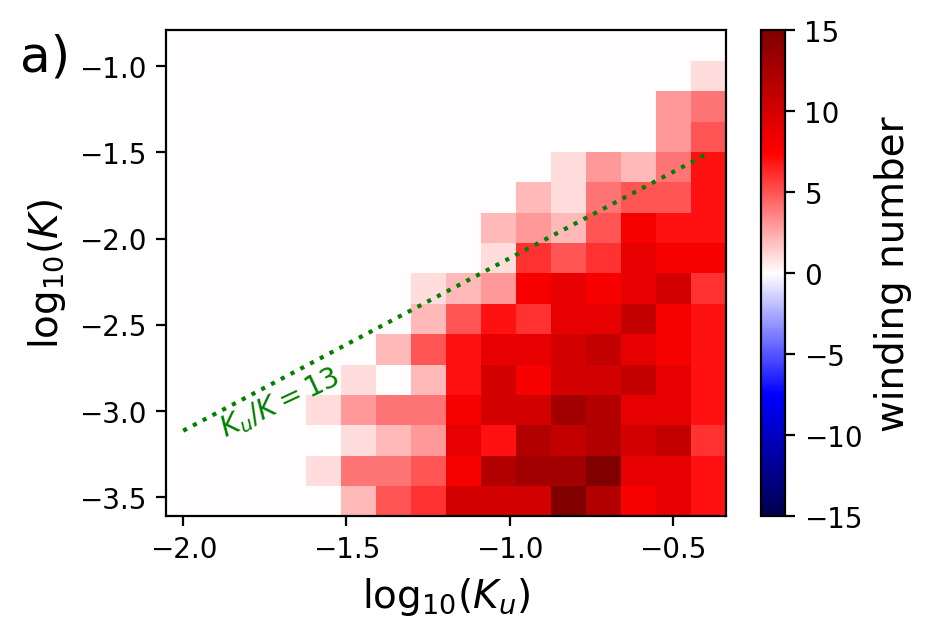

In [568]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.18,right=0.88,bottom=0.17,top=0.98)
c2a = Ku_arr5*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)/hol**2
Kuratio = np.log10(0.5*c2a/nu_arr5)
etaratio = np.log10(0.5*eta5/nu_arr5)
#im=ax.pcolormesh(Kuratio,etaratio,w_arr5,cmap='jet')  
wmax = np.max(w_arr5)
im=ax.pcolormesh(np.log10(Ku_arr5),np.log10(nu_arr5),w_arr5,cmap='seismic'\
                 ,vmin=-wmax,vmax=wmax)  #seismic
ax.set_ylabel(r'$\log_{10}(K)$',fontsize=14)
ax.set_xlabel(r'$\log_{10}(K_u)$',fontsize=14)
cbar = plt.colorbar(im)
#ax.plot([0.03/fac],[0.02/fac],'h',color='yellow')
#ax.plot([-0.06/fac],[0.005/fac],'d',color='lightgreen')
cbar.set_label('winding number',fontsize=14)
fac = 0.5*c2a/nu_arr5
levs = np.array([1,2,4])*200
#CC = ax.contour(np.log10(Ku_arr5),np.log10(nu_arr5),fac, levels=levs,\
#               colors=['white','red','black'], \
#                linestyles=['solid', 'dashed',  'dotted'],\
#                linewidths=[1,1.5,2]) #'dashdot',
#cbar.add_lines(CC)
# is ov1 K_u=0.2;       nu_p=0.002; nu_m=nu_p; eta = 1e-4  # noise
#ax.plot([np.log10(0.2)],[np.log10(0.002)],'ko',ms=6) #'OVN1' simulation
#ax.plot([np.log10(0.2)],[np.log10(0.002)],'wo',ms=2)

xlin = np.linspace(np.min(np.log10(Ku_arr5)), np.max(np.log10(Ku_arr5)),10)
ylin = xlin - np.log10(13)
ax.plot(xlin,ylin,'g:')
ax.text(-1.9,-3.15,r'$K_u/K=13$',rotation=25,color='green')

ax.text(-2.5,-1.03,'a)',fontsize=18)
plt.savefig('ov_noise3_mm.png',dpi=300)
print('Ku ',np.min(Ku_arr5),np.max(Ku_arr5))
print('nu ',np.min(nu_arr5),np.max(nu_arr5))


Ku  0.01 0.40564819207303354
nu  0.0003 0.1313681671142578


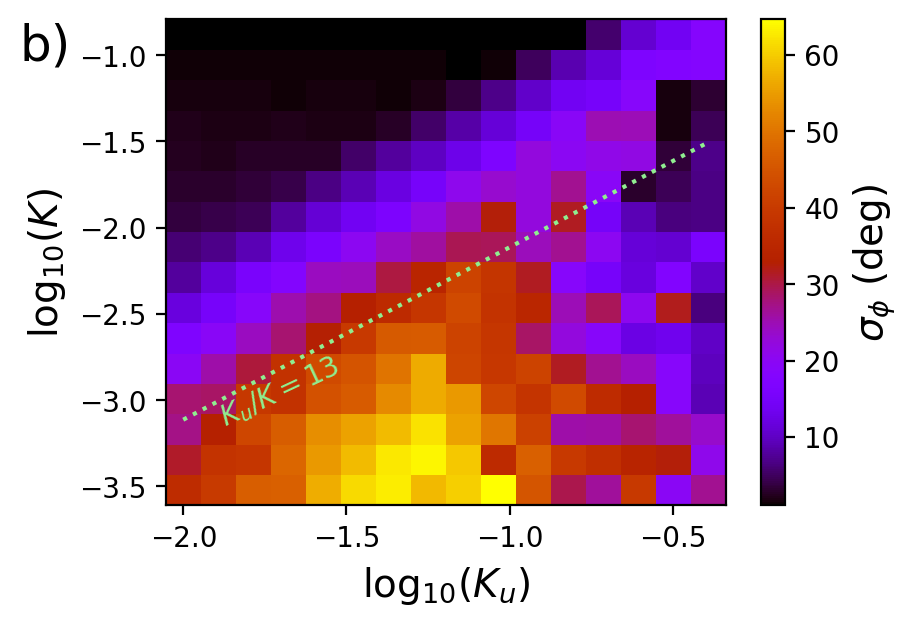

In [570]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.18,right=0.88,bottom=0.17,top=0.98)
c2a = Ku_arr5*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)/hol**2
Kuratio = np.log10(0.5*c2a/nu_arr5)
etaratio = np.log10(0.5*eta5/nu_arr5)
#im=ax.pcolormesh(Kuratio,etaratio,w_arr5,cmap='jet')  
im=ax.pcolormesh(np.log10(Ku_arr5),np.log10(nu_arr5),\
                 p_arr5*180/np.pi,cmap='gnuplot')  #seismic
ax.set_ylabel(r'$\log_{10}(K)$',fontsize=14)
ax.set_xlabel(r'$\log_{10}(K_u)$',fontsize=14)
cbar = plt.colorbar(im)
#ax.plot([0.03/fac],[0.02/fac],'h',color='yellow')
#ax.plot([-0.06/fac],[0.005/fac],'d',color='lightgreen')
#cbar.set_label('winding number',fontsize=14)
cbar.set_label(r'$\sigma_\phi$ (deg)',fontsize=14)
fac = 0.5*c2a/nu_arr5
levs = np.array([1,2,4])*200


xlin = np.linspace(np.min(np.log10(Ku_arr5)), np.max(np.log10(Ku_arr5)),10)
ylin = xlin - np.log10(13)
ax.plot(xlin,ylin,':',color='lightgreen')
ax.text(-1.9,-3.15,r'$K_u/K=13$',rotation=25,color='lightgreen')

ax.text(-2.5,-1.03,'b)',fontsize=18)
plt.savefig('ov_noise3_sig_mm.png',dpi=300)
print('Ku ',np.min(Ku_arr5),np.max(Ku_arr5))
print('nu ',np.min(nu_arr5),np.max(nu_arr5))

In [578]:
def mkfigs_ov3(Ku_arr,nu_arr,w_arr,p_arr,eta):

    fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
    plt.subplots_adjust(left=0.18,right=0.88,bottom=0.17,top=0.98)
    c2a = Ku_arr*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)/hol**2
    #Kuratio = np.log10(0.5*c2a/nu_arr)
    #etaratio = np.log10(0.5*eta5/nu_arr)

    wmax = np.max(w_arr)
    im=ax.pcolormesh(np.log10(Ku_arr),np.log10(nu_arr),w_arr,cmap='seismic'\
                 ,vmin=-wmax,vmax=wmax)  #seismic
    ax.set_ylabel(r'$\log_{10}(K)$',fontsize=14)
    ax.set_xlabel(r'$\log_{10}(K_u)$',fontsize=14)
    cbar = plt.colorbar(im)
    cbar.set_label('winding number',fontsize=14)
    
    xlin = np.linspace(np.min(np.log10(Ku_arr)), np.max(np.log10(Ku_arr)),10)
    ylin = xlin - np.log10(13)
    ax.plot(xlin,ylin,'g:')
    ax.text(-1.9,-3.2,r'$K_u/K=13$',rotation=27,color='green')
    #ax.text(-2.5,-1.03,'a)',fontsize=18)
    #plt.savefig('ov_noise3.png',dpi=300)
    
    fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
    plt.subplots_adjust(left=0.18,right=0.88,bottom=0.17,top=0.98)

    im=ax.pcolormesh(np.log10(Ku_arr),np.log10(nu_arr),\
                 p_arr*180/np.pi,cmap='gnuplot')  
    ax.set_ylabel(r'$\log_{10}(K)$',fontsize=14)
    ax.set_xlabel(r'$\log_{10}(K_u)$',fontsize=14)
    cbar = plt.colorbar(im)
    cbar.set_label(r'$\sigma_\phi$ (deg)',fontsize=14)

    #ax.text(-2.5,-1.03,'b)',fontsize=18)
    #plt.savefig('ov_noise3_sig.png',dpi=300)
    print('Ku ',np.min(Ku_arr),np.max(Ku_arr))
    print('nu ',np.min(nu_arr),np.max(nu_arr))
    

#mkfigs_ov3(Ku_arr5b,nu_arr5b,w_arr5b,p_arr5b,eta5b)

In [534]:
N=100
Ku_start = 0.01;
nu_start = 0.0003;
eta5b = 1e-2
fac_Ku = 1.33
fac_nu =1.6
ni = 16; nj = 16  #ni for Ku loop
hol=0.05; beta=0.1;  
Ku_arr5b,nu_arr5b,w_arr5b,p_arr5b = \
    doloop_long_ov3(N,beta,hol,eta5b,Ku_start,nu_start,fac_Ku,fac_nu,ni,nj,1)


tmax = 601
eta=0.0100, Ku=0.0100 nu_p=0.0003, eta/nu2=16.6667, c2a/nu2=1.1352,  w from 0 to 1
eta=0.0100, Ku=0.0100 nu_p=0.0005, eta/nu2=10.4167, c2a/nu2=0.7095,  w from 0 to -0
eta=0.0100, Ku=0.0100 nu_p=0.0008, eta/nu2=6.5104, c2a/nu2=0.4434,  w from 0 to -1
eta=0.0100, Ku=0.0100 nu_p=0.0012, eta/nu2=4.0690, c2a/nu2=0.2771,  w from 0 to -7
eta=0.0100, Ku=0.0100 nu_p=0.0020, eta/nu2=2.5431, c2a/nu2=0.1732,  w from 0 to -3
eta=0.0100, Ku=0.0100 nu_p=0.0031, eta/nu2=1.5895, c2a/nu2=0.1083,  w from 0 to 0
eta=0.0100, Ku=0.0100 nu_p=0.0050, eta/nu2=0.9934, c2a/nu2=0.0677,  w from 0 to 4
eta=0.0100, Ku=0.0100 nu_p=0.0081, eta/nu2=0.6209, c2a/nu2=0.0423,  w from 0 to -1
eta=0.0100, Ku=0.0100 nu_p=0.0129, eta/nu2=0.3881, c2a/nu2=0.0264,  w from 0 to -0
eta=0.0100, Ku=0.0100 nu_p=0.0206, eta/nu2=0.2425, c2a/nu2=0.0165,  w from 0 to 0
eta=0.0100, Ku=0.0100 nu_p=0.0330, eta/nu2=0.1516, c2a/nu2=0.0103,  w from 0 to 0
eta=0.0100, Ku=0.0100 nu_p=0.0528, eta/nu2=0.0947, c2a/nu2=0.0065,  w from 0 to

eta=0.0100, Ku=0.0553 nu_p=0.0020, eta/nu2=2.5431, c2a/nu2=0.9587,  w from -0 to 4
eta=0.0100, Ku=0.0553 nu_p=0.0031, eta/nu2=1.5895, c2a/nu2=0.5992,  w from 0 to 4
eta=0.0100, Ku=0.0553 nu_p=0.0050, eta/nu2=0.9934, c2a/nu2=0.3745,  w from 0 to 2
eta=0.0100, Ku=0.0553 nu_p=0.0081, eta/nu2=0.6209, c2a/nu2=0.2341,  w from 0 to 2
eta=0.0100, Ku=0.0553 nu_p=0.0129, eta/nu2=0.3881, c2a/nu2=0.1463,  w from 0 to 3
eta=0.0100, Ku=0.0553 nu_p=0.0206, eta/nu2=0.2425, c2a/nu2=0.0914,  w from 0 to 1
eta=0.0100, Ku=0.0553 nu_p=0.0330, eta/nu2=0.1516, c2a/nu2=0.0571,  w from 0 to -0
eta=0.0100, Ku=0.0553 nu_p=0.0528, eta/nu2=0.0947, c2a/nu2=0.0357,  w from 0 to 0
eta=0.0100, Ku=0.0553 nu_p=0.0844, eta/nu2=0.0592, c2a/nu2=0.0223,  w from 0 to 0
eta=0.0100, Ku=0.0553 nu_p=0.1351, eta/nu2=0.0370, c2a/nu2=0.0140,  w from 0 to 0
eta=0.0100, Ku=0.0553 nu_p=0.2162, eta/nu2=0.0231, c2a/nu2=0.0087,  w from 0 to 0
eta=0.0100, Ku=0.0553 nu_p=0.3459, eta/nu2=0.0145, c2a/nu2=0.0054,  w from 0 to 0
eta=0.0100, Ku

eta=0.0100, Ku=0.3064 nu_p=0.0129, eta/nu2=0.3881, c2a/nu2=0.8097,  w from 0 to 9
eta=0.0100, Ku=0.3064 nu_p=0.0206, eta/nu2=0.2425, c2a/nu2=0.5061,  w from 0 to 9
eta=0.0100, Ku=0.3064 nu_p=0.0330, eta/nu2=0.1516, c2a/nu2=0.3163,  w from 0 to 4
eta=0.0100, Ku=0.3064 nu_p=0.0528, eta/nu2=0.0947, c2a/nu2=0.1977,  w from 0 to 0
eta=0.0100, Ku=0.3064 nu_p=0.0844, eta/nu2=0.0592, c2a/nu2=0.1235,  w from 0 to -0
eta=0.0100, Ku=0.3064 nu_p=0.1351, eta/nu2=0.0370, c2a/nu2=0.0772,  w from 0 to -0
eta=0.0100, Ku=0.3064 nu_p=0.2162, eta/nu2=0.0231, c2a/nu2=0.0483,  w from 0 to 0
eta=0.0100, Ku=0.3064 nu_p=0.3459, eta/nu2=0.0145, c2a/nu2=0.0302,  w from 0 to 0
eta=0.0100, Ku=0.4074 nu_p=0.0003, eta/nu2=16.6667, c2a/nu2=46.2516,  w from 0 to 13
eta=0.0100, Ku=0.4074 nu_p=0.0005, eta/nu2=10.4167, c2a/nu2=28.9073,  w from 0 to 9
eta=0.0100, Ku=0.4074 nu_p=0.0008, eta/nu2=6.5104, c2a/nu2=18.0670,  w from 0 to 8
eta=0.0100, Ku=0.4074 nu_p=0.0012, eta/nu2=4.0690, c2a/nu2=11.2919,  w from 0 to 12
eta=0.

Ku  0.01 0.7207333436458895
nu  0.0003 0.34587645138205436


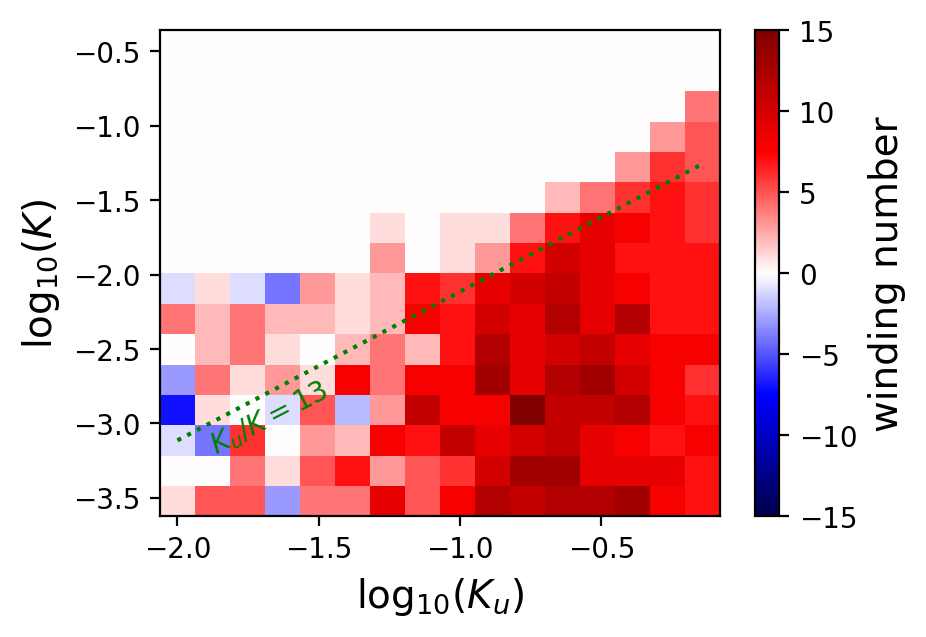

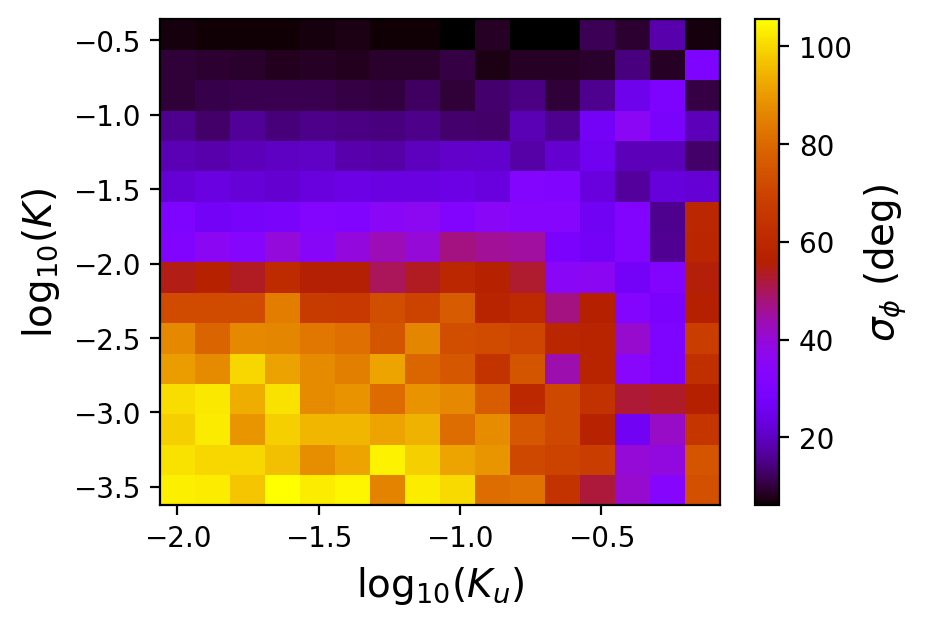

In [579]:
mkfigs_ov3(Ku_arr5b,nu_arr5b,w_arr5b,p_arr5b,eta5b)

In [535]:
N=100
Ku_start = 0.01;
nu_start = 0.0003;
eta5c = 1e-6
fac_Ku = 1.33
fac_nu =1.6
ni = 16; nj = 16  #ni for Ku loop
hol=0.05; beta=0.1;  
Ku_arr5c,nu_arr5c,w_arr5c,p_arr5c = \
    doloop_long_ov3(N,beta,hol,eta5c,Ku_start,nu_start,fac_Ku,fac_nu,ni,nj,1)


tmax = 601
eta=0.0000, Ku=0.0100 nu_p=0.0003, eta/nu2=0.0017, c2a/nu2=1.1352,  w from 0 to 0
eta=0.0000, Ku=0.0100 nu_p=0.0005, eta/nu2=0.0010, c2a/nu2=0.7095,  w from 0 to 0
eta=0.0000, Ku=0.0100 nu_p=0.0008, eta/nu2=0.0007, c2a/nu2=0.4434,  w from 0 to 0
eta=0.0000, Ku=0.0100 nu_p=0.0012, eta/nu2=0.0004, c2a/nu2=0.2771,  w from 0 to 0
eta=0.0000, Ku=0.0100 nu_p=0.0020, eta/nu2=0.0003, c2a/nu2=0.1732,  w from 0 to 0
eta=0.0000, Ku=0.0100 nu_p=0.0031, eta/nu2=0.0002, c2a/nu2=0.1083,  w from 0 to 0
eta=0.0000, Ku=0.0100 nu_p=0.0050, eta/nu2=0.0001, c2a/nu2=0.0677,  w from 0 to 0
eta=0.0000, Ku=0.0100 nu_p=0.0081, eta/nu2=0.0001, c2a/nu2=0.0423,  w from 0 to 0
eta=0.0000, Ku=0.0100 nu_p=0.0129, eta/nu2=0.0000, c2a/nu2=0.0264,  w from 0 to 0
eta=0.0000, Ku=0.0100 nu_p=0.0206, eta/nu2=0.0000, c2a/nu2=0.0165,  w from 0 to 0
eta=0.0000, Ku=0.0100 nu_p=0.0330, eta/nu2=0.0000, c2a/nu2=0.0103,  w from 0 to 0
eta=0.0000, Ku=0.0100 nu_p=0.0528, eta/nu2=0.0000, c2a/nu2=0.0065,  w from 0 to 0
eta=0

eta=0.0000, Ku=0.0553 nu_p=0.0020, eta/nu2=0.0003, c2a/nu2=0.9587,  w from 0 to 0
eta=0.0000, Ku=0.0553 nu_p=0.0031, eta/nu2=0.0002, c2a/nu2=0.5992,  w from 0 to -0
eta=0.0000, Ku=0.0553 nu_p=0.0050, eta/nu2=0.0001, c2a/nu2=0.3745,  w from 0 to -0
eta=0.0000, Ku=0.0553 nu_p=0.0081, eta/nu2=0.0001, c2a/nu2=0.2341,  w from 0 to 0
eta=0.0000, Ku=0.0553 nu_p=0.0129, eta/nu2=0.0000, c2a/nu2=0.1463,  w from 0 to 0
eta=0.0000, Ku=0.0553 nu_p=0.0206, eta/nu2=0.0000, c2a/nu2=0.0914,  w from 0 to 0
eta=0.0000, Ku=0.0553 nu_p=0.0330, eta/nu2=0.0000, c2a/nu2=0.0571,  w from 0 to 0
eta=0.0000, Ku=0.0553 nu_p=0.0528, eta/nu2=0.0000, c2a/nu2=0.0357,  w from 0 to 0
eta=0.0000, Ku=0.0553 nu_p=0.0844, eta/nu2=0.0000, c2a/nu2=0.0223,  w from 0 to 0
eta=0.0000, Ku=0.0553 nu_p=0.1351, eta/nu2=0.0000, c2a/nu2=0.0140,  w from 0 to 0
eta=0.0000, Ku=0.0553 nu_p=0.2162, eta/nu2=0.0000, c2a/nu2=0.0087,  w from 0 to 0
eta=0.0000, Ku=0.0553 nu_p=0.3459, eta/nu2=0.0000, c2a/nu2=0.0054,  w from 0 to 0
eta=0.0000, Ku

eta=0.0000, Ku=0.3064 nu_p=0.0129, eta/nu2=0.0000, c2a/nu2=0.8097,  w from 0 to 6
eta=0.0000, Ku=0.3064 nu_p=0.0206, eta/nu2=0.0000, c2a/nu2=0.5061,  w from 0 to 4
eta=0.0000, Ku=0.3064 nu_p=0.0330, eta/nu2=0.0000, c2a/nu2=0.3163,  w from 0 to 0
eta=0.0000, Ku=0.3064 nu_p=0.0528, eta/nu2=0.0000, c2a/nu2=0.1977,  w from 0 to 0
eta=0.0000, Ku=0.3064 nu_p=0.0844, eta/nu2=0.0000, c2a/nu2=0.1235,  w from 0 to 0
eta=0.0000, Ku=0.3064 nu_p=0.1351, eta/nu2=0.0000, c2a/nu2=0.0772,  w from 0 to 0
eta=0.0000, Ku=0.3064 nu_p=0.2162, eta/nu2=0.0000, c2a/nu2=0.0483,  w from 0 to 0
eta=0.0000, Ku=0.3064 nu_p=0.3459, eta/nu2=0.0000, c2a/nu2=0.0302,  w from 0 to 0
eta=0.0000, Ku=0.4074 nu_p=0.0003, eta/nu2=0.0017, c2a/nu2=46.2516,  w from 0 to 5
eta=0.0000, Ku=0.4074 nu_p=0.0005, eta/nu2=0.0010, c2a/nu2=28.9073,  w from 0 to 8
eta=0.0000, Ku=0.4074 nu_p=0.0008, eta/nu2=0.0007, c2a/nu2=18.0670,  w from 0 to 6
eta=0.0000, Ku=0.4074 nu_p=0.0012, eta/nu2=0.0004, c2a/nu2=11.2919,  w from 0 to 6
eta=0.0000, 

Ku  0.01 0.7207333436458895
nu  0.0003 0.34587645138205436


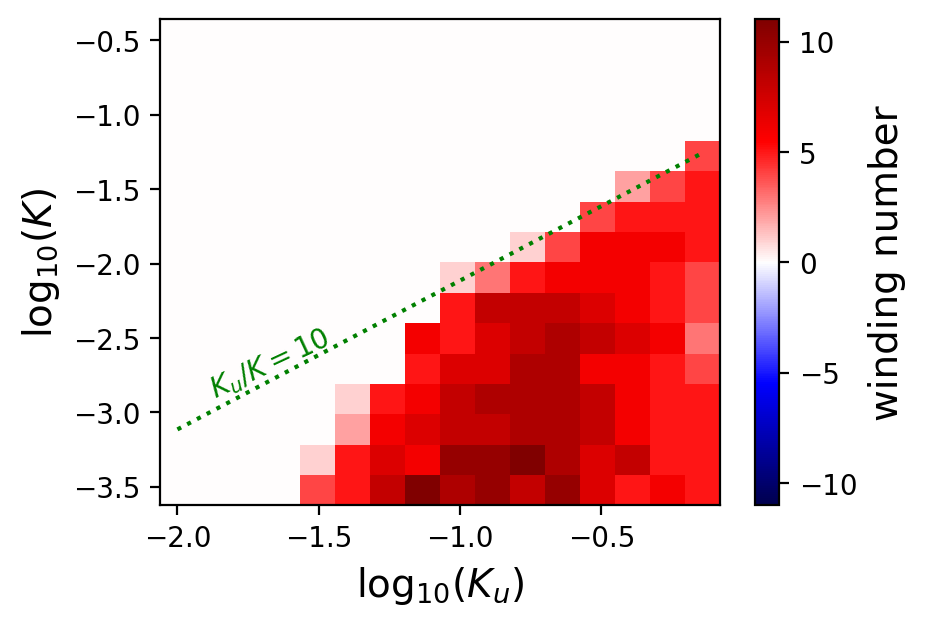

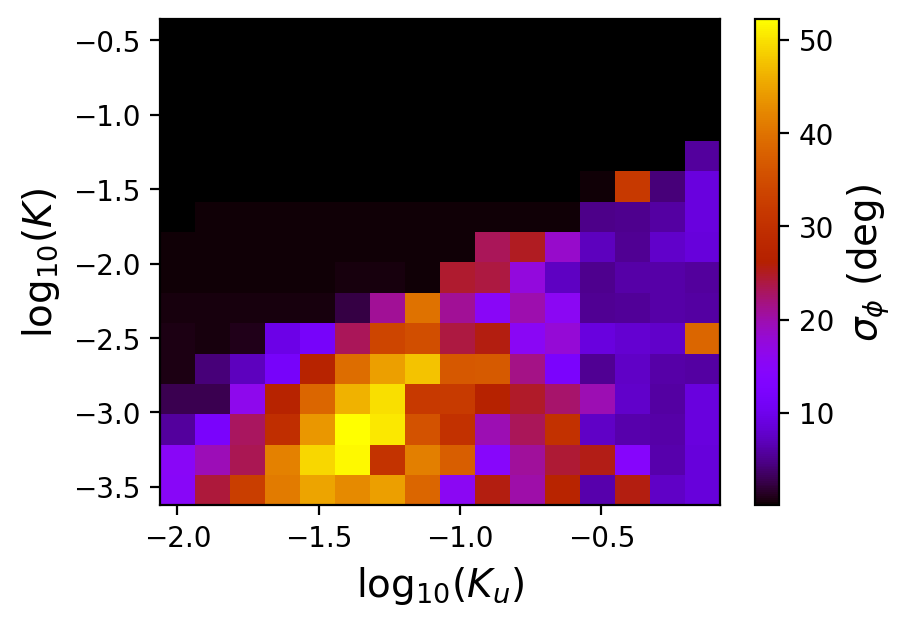

In [575]:
mkfigs_ov3(Ku_arr5c,nu_arr5c,w_arr5c,p_arr5c,eta5c)

0.01 0.2842170943040401
5e-05 0.0014210854715202004


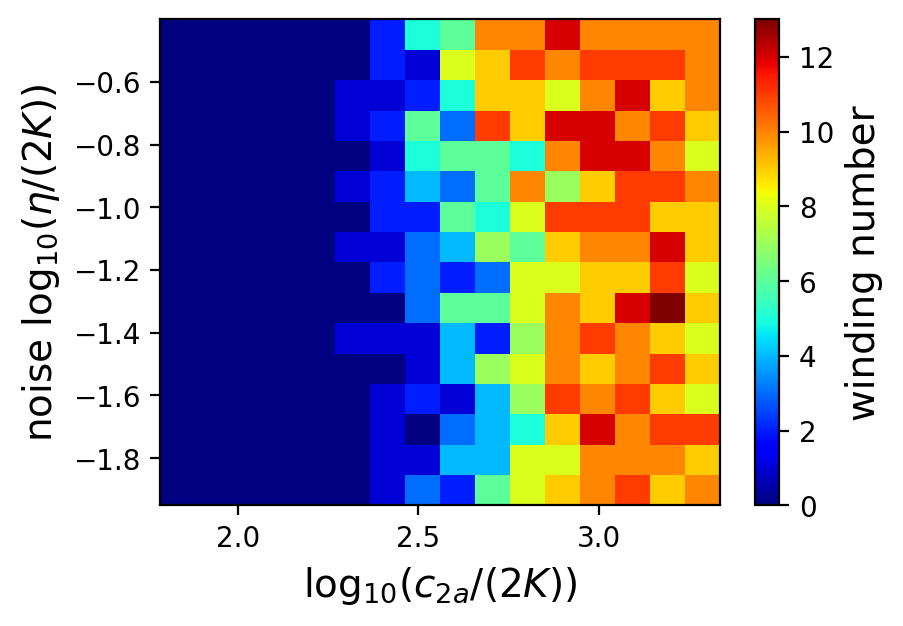

In [339]:
fig, ax = plt.subplots(1,1,figsize=(5,3),dpi=200,facecolor='white')
plt.subplots_adjust(left=0.18,right=0.88,bottom=0.17,top=0.98)
c2a = Ku_arr4*omega0/(np.cosh(beta/hol)*np.cosh(beta/hol))*np.tanh(beta/hol)/hol**2
#print('c2a = {:.5f}'.format(c2a))
Kuratio = np.log10(0.5*c2a/nu4)
etaratio = np.log10(0.5*eta_arr4/nu4)
im=ax.pcolormesh(Kuratio,etaratio,w_arr4,cmap='jet')  #seismic
#im=ax.pcolormesh(np.log10(Ku_arr4),np.log10(eta_arr4),w_arr4,cmap='jet')  #seismic
ax.set_ylabel(r'noise $\log_{10}(\eta/(2K))$',fontsize=14)
ax.set_xlabel(r'$\log_{10}(c_{2a}/(2K))$',fontsize=14)
cbar = plt.colorbar(im)
#ax.plot([0.03/fac],[0.02/fac],'h',color='yellow')
#ax.plot([-0.06/fac],[0.005/fac],'d',color='lightgreen')
cbar.set_label('winding number',fontsize=14)
#ax.text(-3.8,-2.6,'x)',fontsize=18)
#plt.savefig('ov_noise2.png',dpi=300)
print(np.min(Ku_arr4),np.max(Ku_arr4))
print(np.min(eta_arr4),np.max(eta_arr4))